# Lending club case study - Default Analysis


This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface.

Lending loans to ‘risky’ applicants is the largest source of financial loss (called credit loss). Credit loss is the amount of money lost by the lender when the borrower doesn't pay back. These customers labelled as 'charged-off' are the 'defaulters'. 

Identification & understanding the driving factors behind loan default can be useful for portfolio and risk assessment.
By identifying these risky loan applicants, such loans can be reduced to avoid credit loss.

In [1]:
import pandas as pd #type:ignore
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore
import seaborn as sns #type:ignore

plt.style.use('default')

In [2]:
print("below code was made with below versions")
print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
import matplotlib #type:ignore
print("matplotlib version: " + matplotlib.__version__) #type:ignore
print("seaborn version: " + sns.__version__) #type:ignore

below code was made with below versions
pandas version: 2.1.1
numpy version: 1.24.3
matplotlib version: 3.8.0
seaborn version: 0.13.2


# 1. Data understanding

In [3]:
df = pd.read_csv("loan.csv", low_memory=False)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [5]:
df.shape

(39717, 111)

In [6]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

loan_status column is the target variable. It will be comapared against all other independednt variables to undestand important variables

In [7]:
df['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

In [8]:
# % Percentage of charged off items
df['loan_status'].value_counts() / len(df.index) * 100

loan_status
Fully Paid     82.961956
Charged Off    14.167737
Current         2.870307
Name: count, dtype: float64

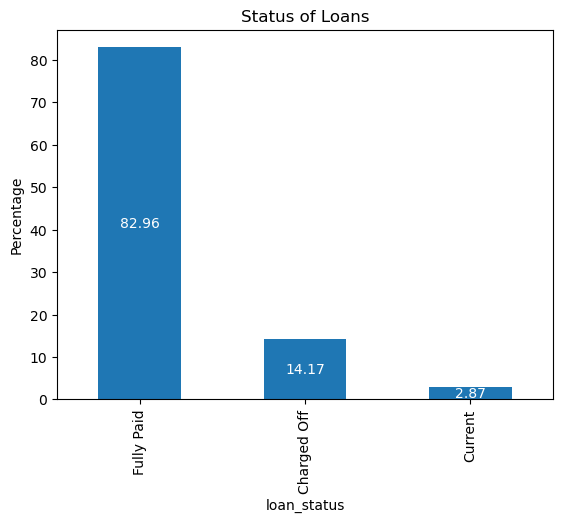

In [9]:
ax = round((df['loan_status'].value_counts(normalize=True) * 100),2).plot(kind='bar', ylabel='Percentage', title='Status of Loans')
plt.bar_label(ax.containers[0], label_type='center', color='w') #type:ignore
plt.show()

14 % of the loans are in charged off category, which is not insignificant. Enough data is present for making inferences and prediciton about default.

# 2. Data Cleaning and Manipulation

### major missing values in columns

In [10]:
# missing values percentage
df.isnull().sum()/len(df.index) * 100

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64

there are columns with 100% missing values, we can delete them

In [11]:
# dropping the columns with na values in entire column
df = df.dropna(axis=1, how='all')
df.shape

(39717, 57)

54 columns were dropped

In [12]:
# missing values percentage more than 0
df.isnull().sum()[df.isnull().sum()> 0].sort_values(ascending=False)/len(df.index) * 100

next_pymnt_d                  97.129693
mths_since_last_record        92.985372
mths_since_last_delinq        64.662487
desc                          32.585543
emp_title                      6.191303
emp_length                     2.706650
pub_rec_bankruptcies           1.754916
last_pymnt_d                   0.178765
collections_12_mths_ex_med     0.140998
chargeoff_within_12_mths       0.140998
revol_util                     0.125891
tax_liens                      0.098195
title                          0.027696
last_credit_pull_d             0.005036
dtype: float64

these remaining columns will be imputed or dropped later based on better data understanding

### major missing values in rows

checking for rows with more than 50% mising values before handling other columns

In [13]:
df.loc[df.isnull().sum(axis=1) >= 0.5*df.shape[1]]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens


all rows are good. not dropping any rows for now

### single unique value columns can be dropped

checking for columns with single value in entire column. They are not useful for analysis as there is only one unique value in entire column.
they can be dropped if they are present.

In [14]:
df.nunique().sort_values().head(10)

tax_liens                     1
delinq_amnt                   1
chargeoff_within_12_mths      1
acc_now_delinq                1
application_type              1
policy_code                   1
collections_12_mths_ex_med    1
pymnt_plan                    1
initial_list_status           1
term                          2
dtype: int64

In [15]:
single_unique_value_columns = df.columns[df.nunique() == 1]
single_unique_value_columns

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [16]:
df.drop(columns=single_unique_value_columns, inplace=True)
df.shape

(39717, 48)

### drop irrelevant columns for current analysis

In [17]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5000.00,863.16,0.0,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0


In [18]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

below columns will be generarted post loan approval. They can not be used for predicting whether applicant will default or not, as they will be not available at application stage. These columns will be dropped

- out_prncp - Remaining outstanding principal for total amount funded
- out_prncp_inv -	Remaining outstanding principal for portion of total amount funded by investors
- total_pymnt	- Payments received to date for total amount funded
- total_pymnt_inv - Payments received to date for portion of total amount funded by investors
- total_rec_prncp - Principal received to date
- total_rec_int - Interest received to date
- total_rec_late_fee - Late fees received to date
- recoveries - post charge off gross recovery
- collection_recovery_fee - post charge off collection fee
- last_pymnt_d - Last month payment was received
- last_pymnt_amnt - Last total payment amount received
- next_pymnt_d - Next scheduled payment date
- last_credit_pull_d - The most recent month LC pulled credit for this loan

In [19]:
post_loan_columns = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                     'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d']

In [20]:
df.drop(columns=post_loan_columns, inplace=True)
df.shape

(39717, 35)

drop other columns based on their relavancy to current analysis

In [21]:
# top columns with most unique values
df.nunique().sort_values(ascending=False).head(20)

id                        39717
member_id                 39717
url                       39717
emp_title                 28820
desc                      26526
revol_bal                 21711
title                     19615
installment               15383
funded_amnt_inv            8205
annual_inc                 5318
dti                        2868
revol_util                 1089
funded_amnt                1041
loan_amnt                   885
zip_code                    823
earliest_cr_line            526
int_rate                    371
mths_since_last_record      111
mths_since_last_delinq       95
total_acc                    82
dtype: int64

In [22]:
df[['id', 'member_id', 'url', 'emp_title', 'desc','title', 'zip_code']].head(5)

,id,member_id,url,emp_title,desc,title,zip_code
0,1077501,1296599,https://lendingclub.com/browse/loanDetail.acti...,NaN,Borrower added on 12/22/11 > I need to upgra...,Computer,860xx
1,1077430,1314167,https://lendingclub.com/browse/loanDetail.acti...,Ryder,Borrower added on 12/22/11 > I plan to use t...,bike,309xx
2,1077175,1313524,https://lendingclub.com/browse/loanDetail.acti...,NaN,NaN,real estate business,606xx
3,1076863,1277178,https://lendingclub.com/browse/loanDetail.acti...,AIR RESOURCES BOARD,Borrower added on 12/21/11 > to pay for prop...,personel,917xx
4,1075358,1311748,https://lendingclub.com/browse/loanDetail.acti...,University Medical Group,Borrower added on 12/21/11 > I plan on combi...,Personal,972xx


all of above columns are not relavant for prediciting loan default. No text analysis is being performed now. can be dropped

In [23]:
df.drop(columns=['id', 'member_id', 'url', 'emp_title', 'desc','title', 'zip_code'], inplace=True)
df.shape

(39717, 28)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               39717 non-null  int64  
 1   funded_amnt             39717 non-null  int64  
 2   funded_amnt_inv         39717 non-null  float64
 3   term                    39717 non-null  object 
 4   int_rate                39717 non-null  object 
 5   installment             39717 non-null  float64
 6   grade                   39717 non-null  object 
 7   sub_grade               39717 non-null  object 
 8   emp_length              38642 non-null  object 
 9   home_ownership          39717 non-null  object 
 10  annual_inc              39717 non-null  float64
 11  verification_status     39717 non-null  object 
 12  issue_d                 39717 non-null  object 
 13  loan_status             39717 non-null  object 
 14  purpose                 39717 non-null

checking for missing values on final selected columns

In [25]:
# missing values percentage more than 0
df.isnull().sum()[df.isnull().sum()> 0].sort_values(ascending=False)/len(df.index) * 100

mths_since_last_record    92.985372
mths_since_last_delinq    64.662487
emp_length                 2.706650
pub_rec_bankruptcies       1.754916
revol_util                 0.125891
dtype: float64

Even though below columns have higher missing values, they may be useful for pedicting default behaviour. Before dropping them, proprtion of missing values for these columns can be checked only for 'Charged off' items.
- mths_since_last_delinq - The number of months since the borrower's last delinquency. - A borrower is considered delinquent when they are behind on payments, which is generally 30 to 90 days, depending on the lender and type of debt.
- mths_since_last_record - The number of months since the last public record. - This includes information on how EMIs and credit card bills are being paid, and if any payments have been missed.

In [26]:
# filtering for charged off row items and finding missing values proportion
df_charged_off = df[df['loan_status'] == 'Charged Off']
(df_charged_off.isnull().sum()[df_charged_off.isnull().sum()> 0].sort_values(ascending=False)/len(df_charged_off.index) * 100) #type:ignore

mths_since_last_record    89.728097
mths_since_last_delinq    61.933535
emp_length                 4.051893
pub_rec_bankruptcies       2.097032
revol_util                 0.284343
dtype: float64

proportion of missing values in 'charged off' items are also high (89% and 61%). They are similar to missing values in total data (92% and 64%). So, they will be dropped.

In [27]:
df.drop(columns=['mths_since_last_record', 'mths_since_last_delinq'], inplace=True)

In [28]:
# missing values percentage more than 0
df.isnull().sum()[df.isnull().sum()> 0].sort_values(ascending=False)/len(df.index) * 100

emp_length              2.706650
pub_rec_bankruptcies    1.754916
revol_util              0.125891
dtype: float64

not cleaning these columns further as these values are low and we are not doing any modeling right now.

### correcting data types by cleaning the text/object columns

In [29]:
text_cols=[column for column in df.columns if df[column].dtype == 'object']
df[text_cols].head(5)

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,addr_state,earliest_cr_line,revol_util
0,36 months,10.65%,B,B2,10+ years,RENT,Verified,Dec-11,Fully Paid,credit_card,AZ,Jan-85,83.70%
1,60 months,15.27%,C,C4,< 1 year,RENT,Source Verified,Dec-11,Charged Off,car,GA,Apr-99,9.40%
2,36 months,15.96%,C,C5,10+ years,RENT,Not Verified,Dec-11,Fully Paid,small_business,IL,Nov-01,98.50%
3,36 months,13.49%,C,C1,10+ years,RENT,Source Verified,Dec-11,Fully Paid,other,CA,Feb-96,21%
4,60 months,12.69%,B,B5,1 year,RENT,Source Verified,Dec-11,Current,other,OR,Jan-96,53.90%


correct text columns with correct type

In [30]:
# remove percent symbol
df['int_rate'] = df['int_rate'].apply(lambda x: x.replace("%","")).astype(float)
df['revol_util'] = df['revol_util'].apply(lambda x: x.replace("%","") if type(x) == str else np.nan).astype(float) #there are null values, hence extra check

#convert to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format="%b-%y", errors='raise')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format="%b-%y", errors='raise')
# correcting the wrong dates in earliest_cr_line
df['earliest_cr_line'] = np.where(df['earliest_cr_line'].dt.year >= 2040, 
                                  df['earliest_cr_line'] + pd.DateOffset(years=-100), 
                                  df['earliest_cr_line'])

#emp length
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float) #type: ignore

In [31]:
df[text_cols].head(5)

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,addr_state,earliest_cr_line,revol_util
0,36 months,10.65,B,B2,10.0,RENT,Verified,2011-12-01,Fully Paid,credit_card,AZ,1985-01-01,83.7
1,60 months,15.27,C,C4,1.0,RENT,Source Verified,2011-12-01,Charged Off,car,GA,1999-04-01,9.4
2,36 months,15.96,C,C5,10.0,RENT,Not Verified,2011-12-01,Fully Paid,small_business,IL,2001-11-01,98.5
3,36 months,13.49,C,C1,10.0,RENT,Source Verified,2011-12-01,Fully Paid,other,CA,1996-02-01,21.0
4,60 months,12.69,B,B5,1.0,RENT,Source Verified,2011-12-01,Current,other,OR,1996-01-01,53.9


all are converted properly

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_amnt             39717 non-null  int64         
 1   funded_amnt           39717 non-null  int64         
 2   funded_amnt_inv       39717 non-null  float64       
 3   term                  39717 non-null  object        
 4   int_rate              39717 non-null  float64       
 5   installment           39717 non-null  float64       
 6   grade                 39717 non-null  object        
 7   sub_grade             39717 non-null  object        
 8   emp_length            38642 non-null  float64       
 9   home_ownership        39717 non-null  object        
 10  annual_inc            39717 non-null  float64       
 11  verification_status   39717 non-null  object        
 12  issue_d               39717 non-null  datetime64[ns]
 13  loan_status     

### rename columns

In [33]:
df.rename(columns={'issue_d':'issue_date', 'dti':'debt_to_income'}, inplace=True)

### store columns in list based on their type

In [34]:
# <50 items is considered as cat_cols altough there is no universal definition. Both numerical and text columns are treated as category varaibiles
cat_cols = [column for column in df.columns if df[column].nunique() <= 50]
remaining_cols = [column for column in df.columns if column not in cat_cols]

num_cols = [column for column in remaining_cols if (df[column].dtype == np.float64) or (df[column].dtype == np.int64)]
object_cols=[column for column in remaining_cols if df[column].dtype == 'object']
date_cols = [column for column in remaining_cols if df[column].dtype == 'datetime64[ns]']

In [35]:
# removing loan status column as that is target variable
cat_cols.remove('loan_status')

# add open accounts to num cols as total accounts was added in num_cols
num_cols = num_cols + ['open_acc']
cat_cols.remove('open_acc')

In [36]:
len(num_cols+cat_cols+object_cols+date_cols)

25

In [37]:
cat_cols, num_cols, object_cols, date_cols

(['term',
  'grade',
  'sub_grade',
  'emp_length',
  'home_ownership',
  'verification_status',
  'purpose',
  'addr_state',
  'delinq_2yrs',
  'inq_last_6mths',
  'pub_rec',
  'pub_rec_bankruptcies'],
 ['loan_amnt',
  'funded_amnt',
  'funded_amnt_inv',
  'int_rate',
  'installment',
  'annual_inc',
  'debt_to_income',
  'revol_bal',
  'revol_util',
  'total_acc',
  'open_acc'],
 [],
 ['issue_date', 'earliest_cr_line'])

### outlier checks

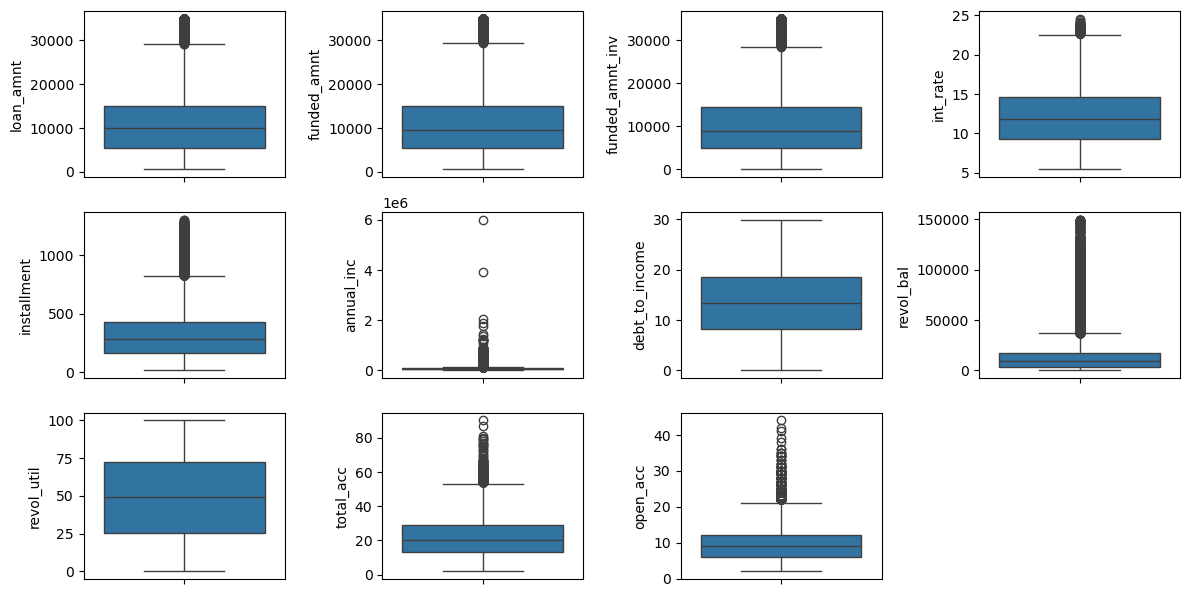

In [38]:
#Check the boxplots to detect the presence of outliers
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(data=df, y=col)
    plt.tight_layout()
plt.show()

outliers are present in all columns except dti, revol_util. we can check for 99.9% percentile values to not to drop many values

In [39]:
for col in num_cols:
    print(f"{col} - 99.9% percentile value: {df[col].quantile(0.999)}")

loan_amnt - 99.9% percentile value: 35000.0
funded_amnt - 99.9% percentile value: 35000.0
funded_amnt_inv - 99.9% percentile value: 35000.0
int_rate - 99.9% percentile value: 23.13
installment - 99.9% percentile value: 1229.9576800000036
annual_inc - 99.9% percentile value: 676858.8800002239
debt_to_income - 99.9% percentile value: 29.44284000000007
revol_bal - 99.9% percentile value: 132767.0960000048
revol_util - 99.9% percentile value: 99.8
total_acc - 99.9% percentile value: 63.0
open_acc - 99.9% percentile value: 30.0


all values looks reasonable. Even though there are outliers, they are looking continuous values. But annual income outliers can be corrected


In [40]:
df.shape

(39717, 26)

In [41]:
df.drop(df[df['annual_inc'] > df['annual_inc'].quantile(0.999)].index, inplace=True)
df.shape

(39677, 26)

around 50 rows are dropped, which is acceptable

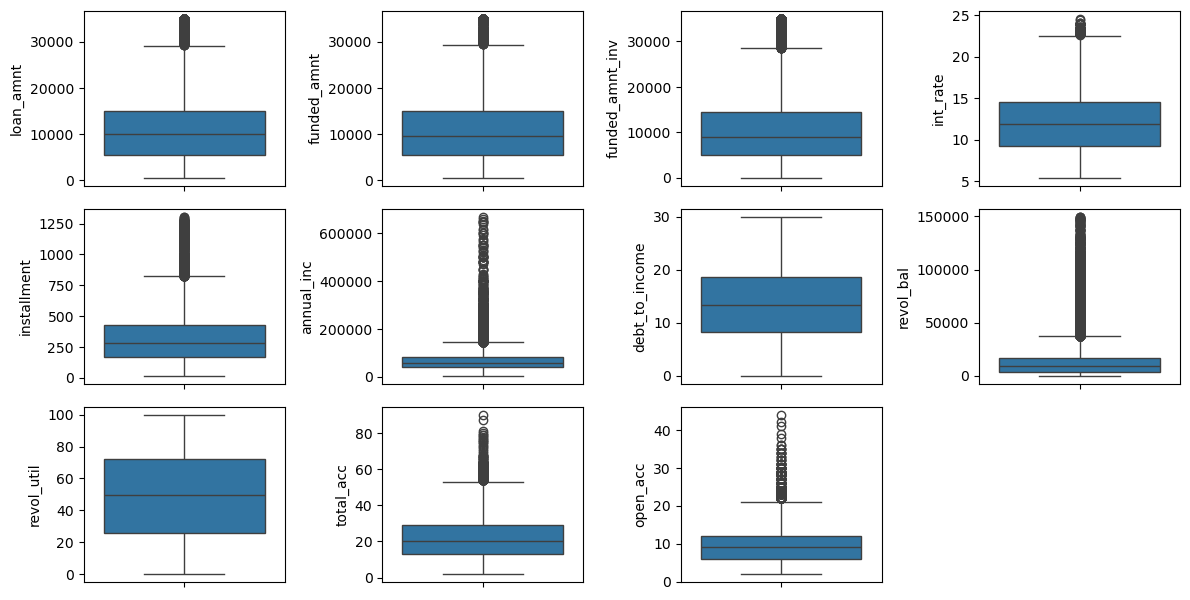

In [42]:
#Check the boxplots again
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(data=df, y=col)
    plt.tight_layout()
plt.show()

all features looks good now.

In [43]:
# checking for mean, median and max to check for outlier impact on mean.
for col in num_cols:
    print(f"{col}: mean - {df[col].mean():.2f}, median - {df[col].median()}, max - {df[col].max()}")

loan_amnt: mean - 11216.60, median - 10000.0, max - 35000
funded_amnt: mean - 10944.89, median - 9600.0, max - 35000
funded_amnt_inv: mean - 10394.78, median - 8975.0, max - 35000.0
int_rate: mean - 12.02, median - 11.86, max - 24.59
installment: mean - 324.48, median - 280.09, max - 1305.19
annual_inc: mean - 67847.15, median - 59000.0, max - 667680.0
debt_to_income: mean - 13.33, median - 13.41, max - 29.99
revol_bal: mean - 13376.12, median - 8850.0, max - 149588
revol_util: mean - 48.84, median - 49.3, max - 99.9
total_acc: mean - 22.09, median - 20.0, max - 90
open_acc: mean - 9.29, median - 9.0, max - 44


in all columns, means are closer to median than max. So, the outlier impact is low on mean

### duplicate checks

In [44]:
df[df.duplicated()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies


no duplicate rows

### Dropping current customers

since we are interested in loan default predictions, 'current' items can be dropped from loan_status column.

In [45]:
df = df[df['loan_status'] != 'Current']

In [46]:
df['loan_status'].value_counts()

loan_status
Fully Paid     32915
Charged Off     5622
Name: count, dtype: int64

# 3. Data analysis

#### statistics of numerical columns

In [47]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,38537.0,11043.919480,7345.344493,500.00,5300.00,9600.00,15000.00,35000.00
funded_amnt,38537.0,10780.985806,7087.032648,500.00,5200.00,9525.00,15000.00,35000.00
funded_amnt_inv,38537.0,10219.550468,7019.612638,0.00,5000.00,8725.00,14000.00,35000.00
int_rate,38537.0,11.932719,3.691611,5.42,8.94,11.71,14.42,24.40
installment,38537.0,322.378369,208.534515,15.69,165.74,277.86,425.55,1305.19
annual_inc,38537.0,67622.815809,43532.969574,4000.00,40000.00,58800.00,82000.00,667680.00
debt_to_income,38537.0,13.284026,6.666168,0.00,8.15,13.38,18.56,29.99
revol_bal,38537.0,13282.795703,15861.565836,0.00,3650.00,8761.00,16903.00,149588.00
revol_util,38487.0,48.707753,28.365340,0.00,25.20,49.10,72.30,99.90
total_acc,38537.0,22.049096,11.424068,2.00,13.00,20.00,29.00,90.00


loan_amount, funded_amount, funded_amount_inv looks similar.

by comparing medians, if 9600 is requested loan amount, funded amount is 9525, which is pretty close to requested loan amount. But, loan_amount may be updated after loan approval using funded_amnt as reference. So, this might also be the reason for their closeness.

invested amount is 8725, which means only 90% is actually funded by investor.

Most representive values for these columns (median values):
- loan amount: Rs. 10000
- interest rate:  12%
- Monthly Installment: Rs. 280
- Annaul Income of applicant: Rs. 60000
- Debt to income ratio: 13
- credit revolving balance: Rs. 9000
- credit revolving utilization: 50%
- Total credit accounts: 20
- current open credit accounts: 9

#### Loan status

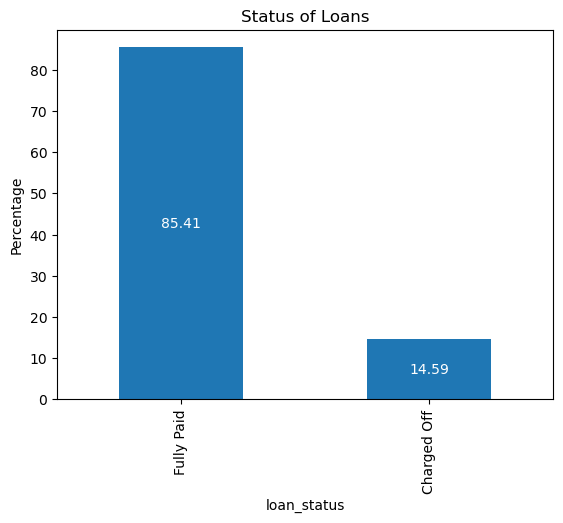

In [48]:
ax = round((df['loan_status'].value_counts(normalize=True) * 100),2).plot(kind='bar', ylabel='Percentage', title='Status of Loans')
plt.bar_label(ax.containers[0], label_type='center', color='w') #type:ignore
plt.show()

after data cleaning, charged off items remains at 14% as it was initially. looks like no mistakes in data cleaning.

### univariate analysis

##### checking the distributions of numerical columns in a grid

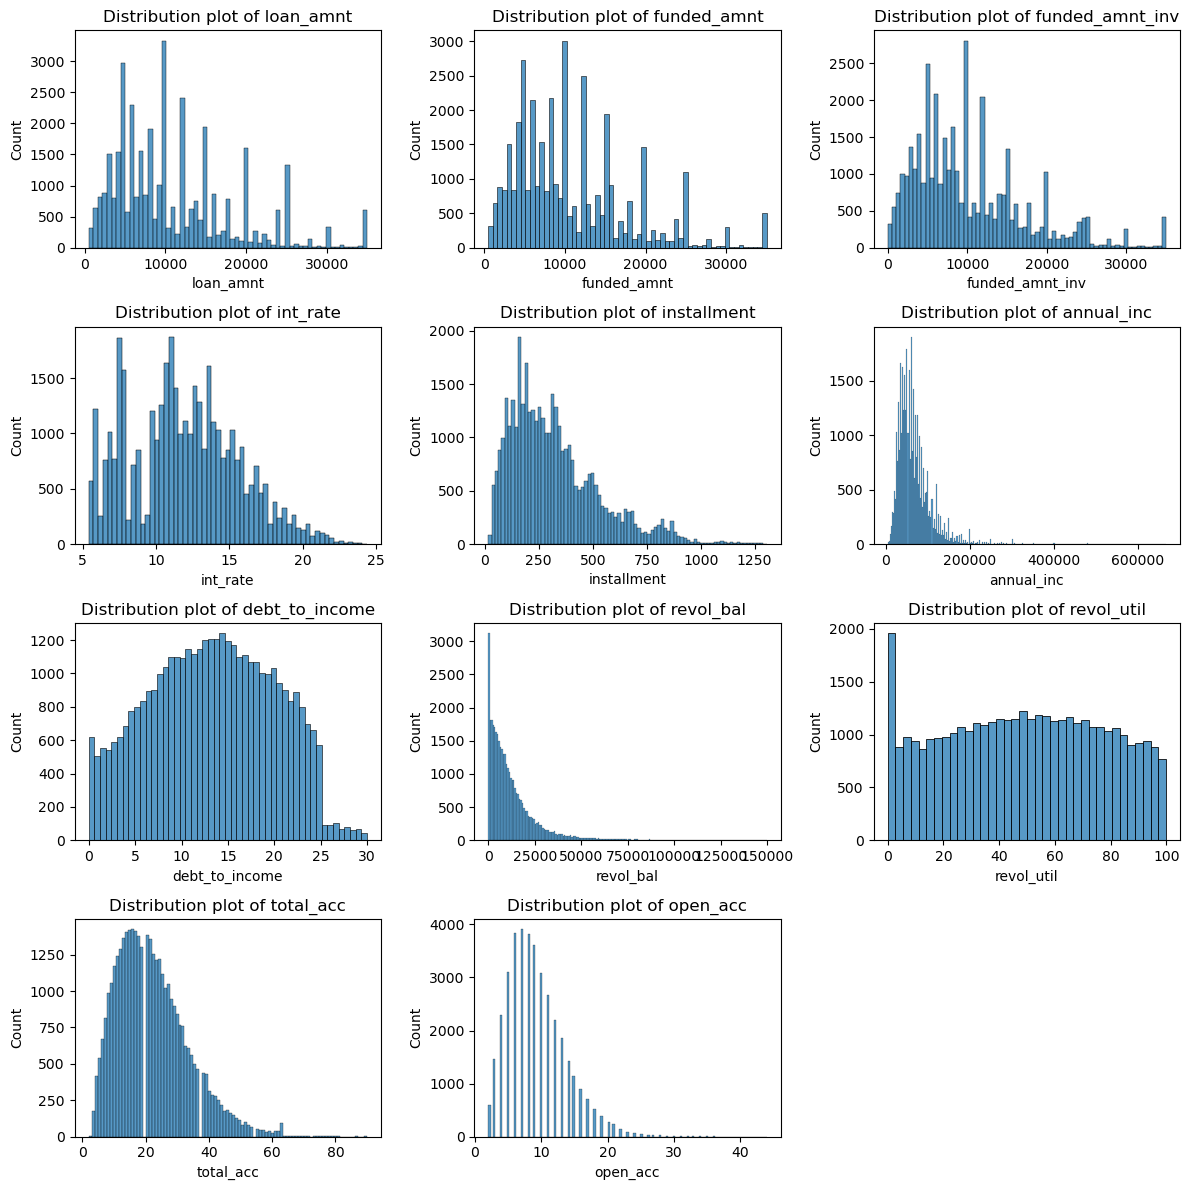

In [49]:
# Check the distributions 
plt.figure(figsize=(12,12))
for i, col in enumerate(num_cols):
    plt.subplot(4,3,i+1)
    sns.histplot(data=df, x=col)
    plt.title('Distribution plot of ' + col)
    plt.tight_layout()
plt.show()

observations:
- loan amount, funded amount and funded amount invested distributions looks same.
- Majority of the loan amounts are round numbers like 5000, 10000, 15000, 20000.

- most of them are right skewed distributions. revol_utii looks like uniform distribution

##### checking the count plots of categorical columns in a grid

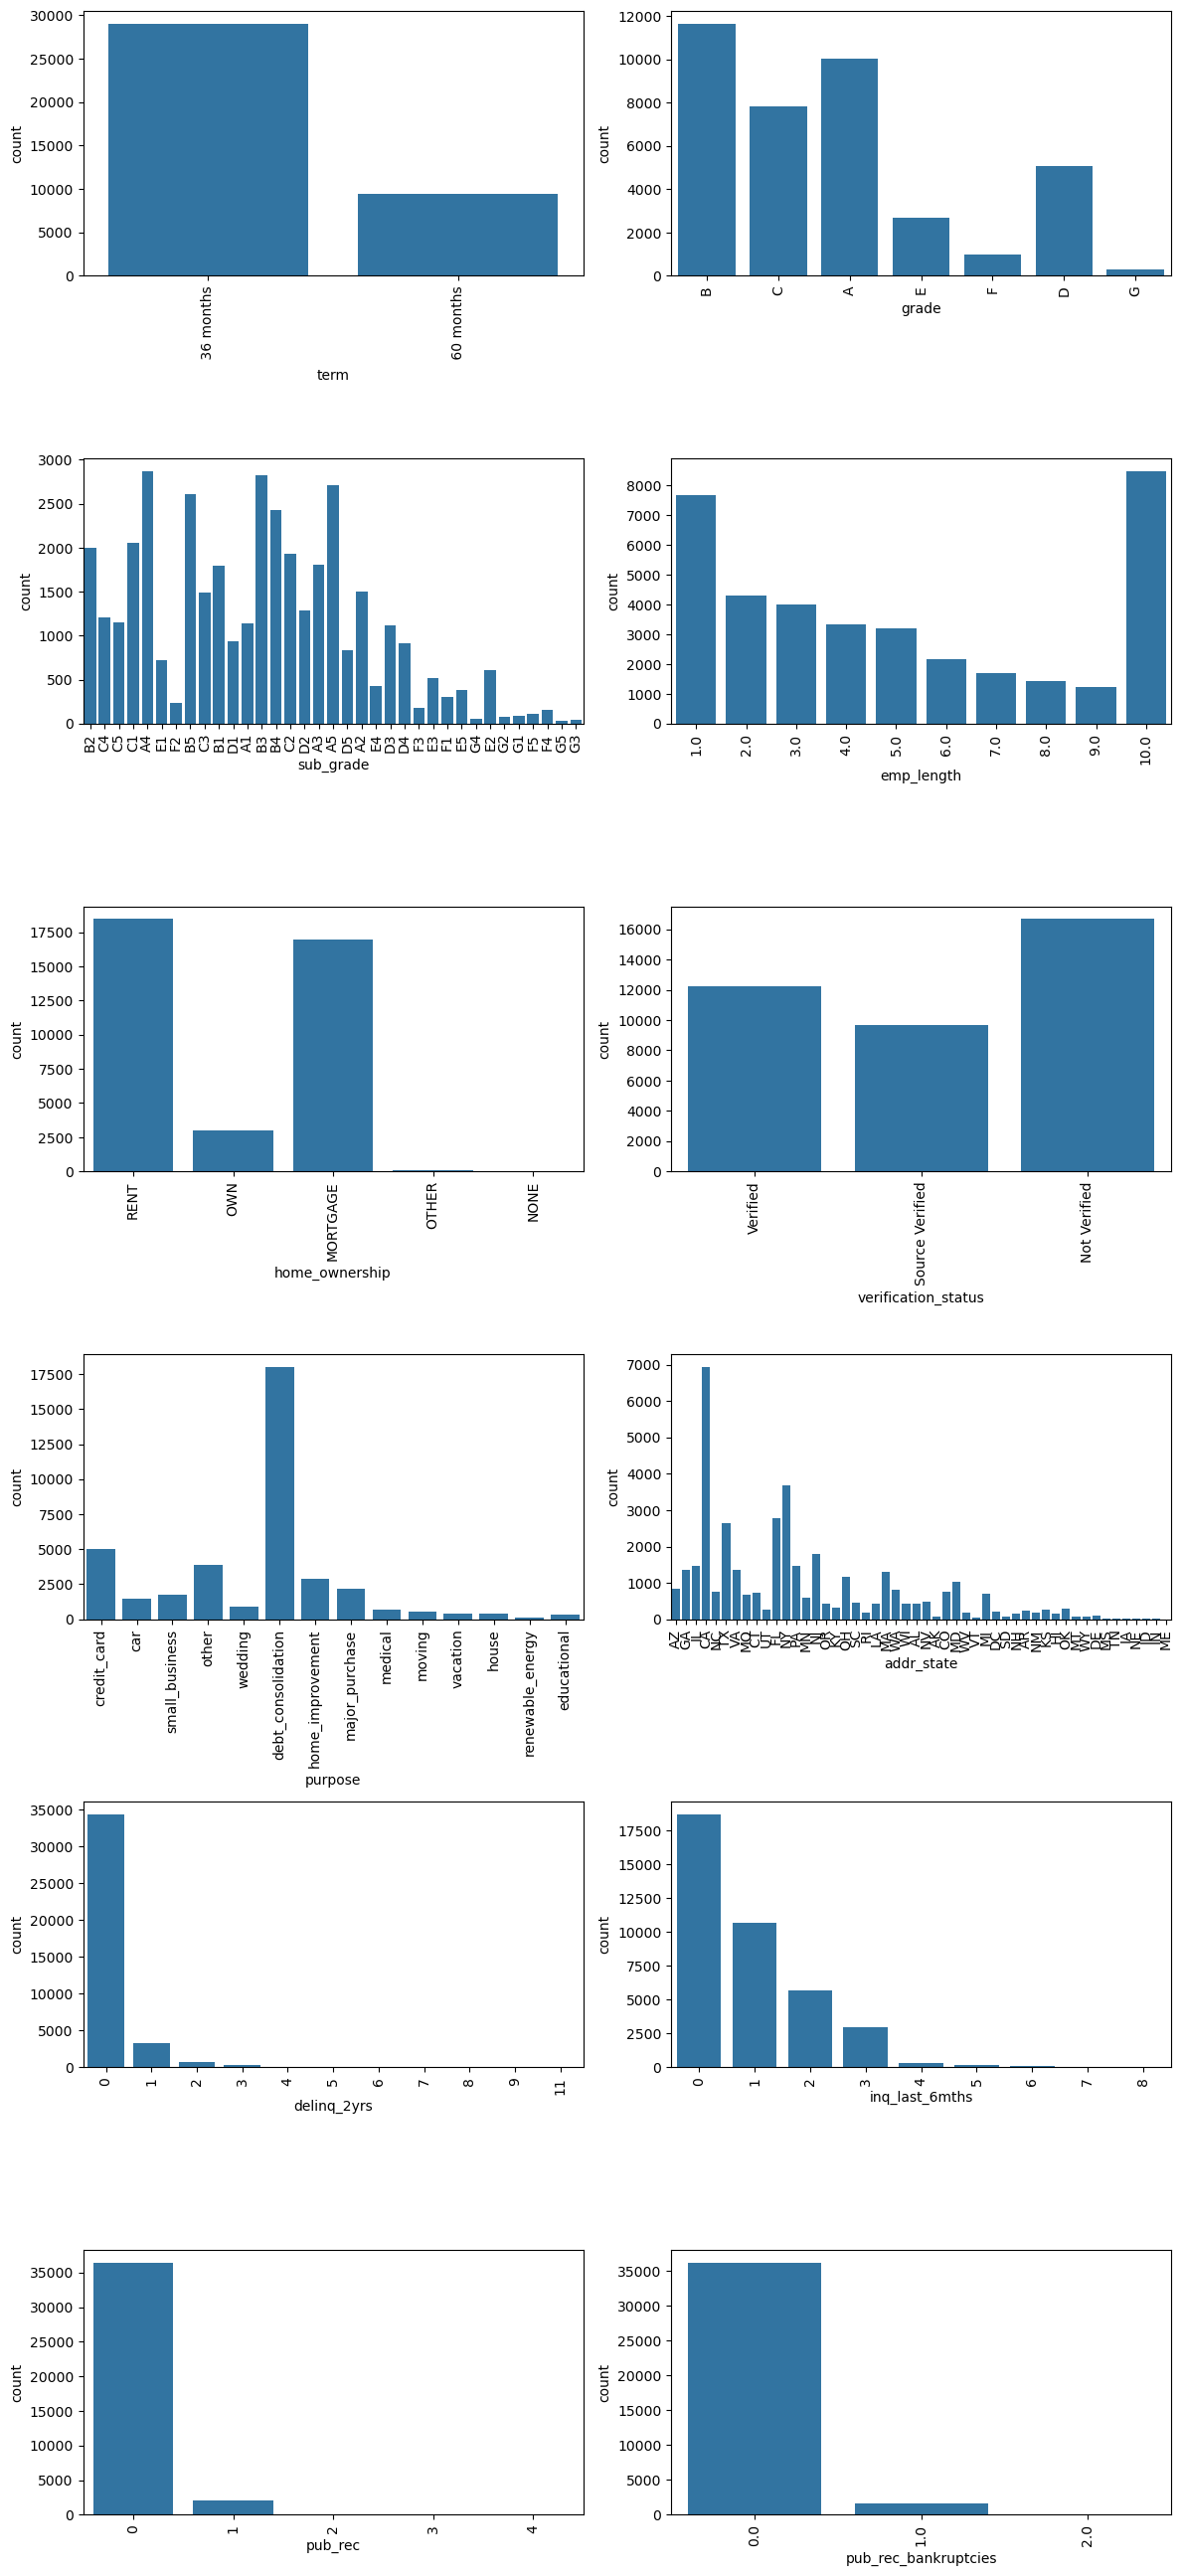

In [50]:
plt.figure(figsize=(12,30))
for i,col in enumerate(cat_cols):
    plt.subplot(7,2,i+1)
    sns.countplot(x=col, data=df) #type: ignore
    plt.xticks(rotation=90)
    plt.tight_layout()
plt.show()

observations:
- Term: 30 months is higher
- Grade: B,A,C,D are major grades in the decreasing order
- employee length: 10+ years is major one, next is 1 years.
- home ownership: Rent, Mortagae are frequent ones.
- income verification: Majority of them are Not verified
- Loan Purpose: top items are debt consolidation, credit card, home improvement, Major Purchase, Small Business.
- Top states: CA - california, NY - newyork, FL - florida, TX - Texas
- delinquency_2yrs - number of incidents are max 11, but after 2, count is negligible
- inquiry_last_6_months - max inquireies are 8, but after 3, count is negligible
- public records - max 4 records, but after 1, count is negligible
- public records of bankruptcies - max 2 bankrupties, but, after 1 count is negligible 

### bivariate analysis

#### bivariate with loan_status and numerical columns - Median

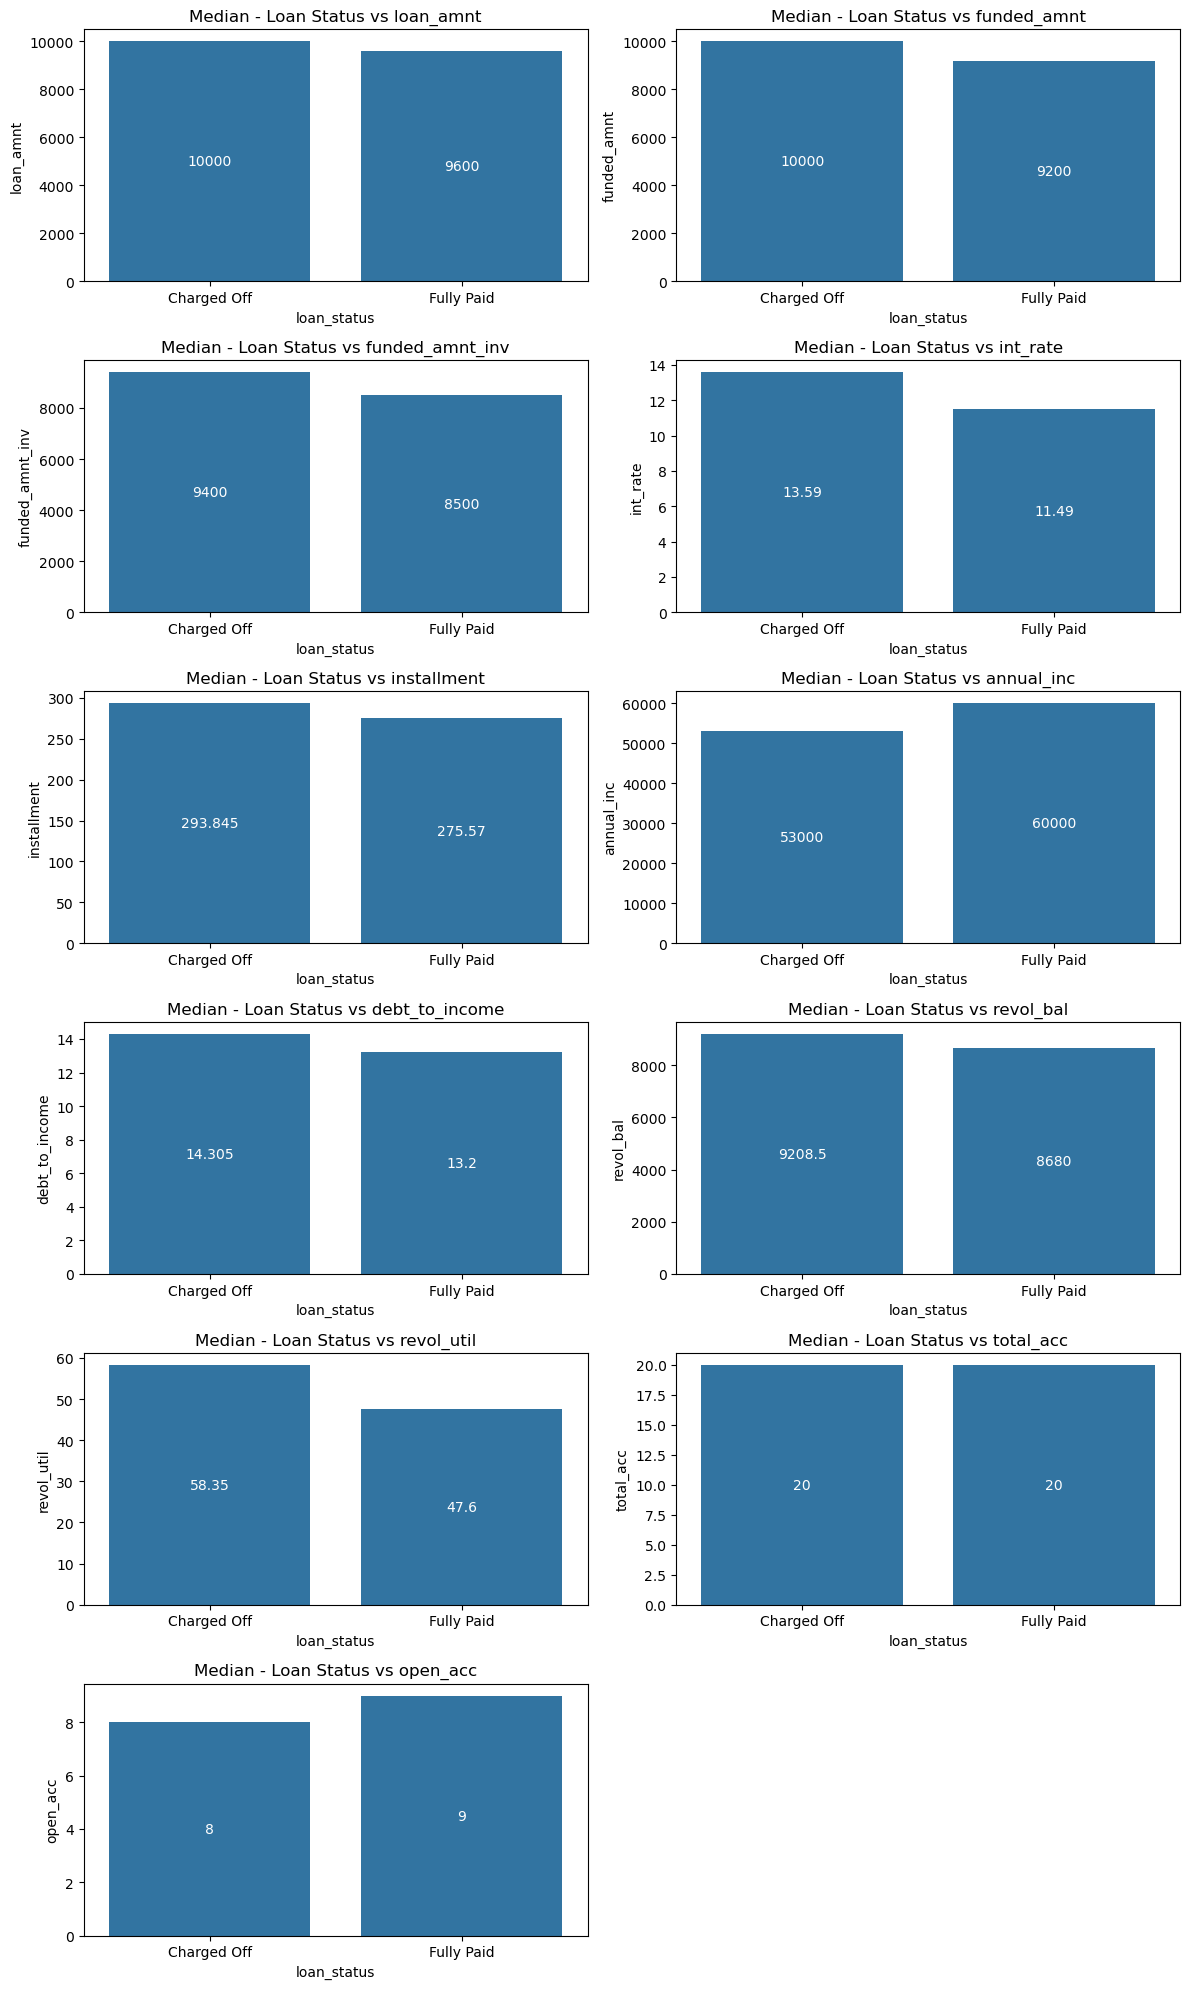

In [51]:
# median values are used to compare
plt.figure(figsize=(12,20))
for i, col in enumerate(num_cols):
    plt.subplot(6,2,i+1)
    ax = sns.barplot(df.groupby('loan_status')[col].median()) #type:ignore
    plt.bar_label(ax.containers[0], label_type='center', color='w') #type:ignore
    plt.title("Median - Loan Status vs " + col)
    plt.tight_layout()
plt.show()

Observations:

Indicators for charged off items.
- loan amount, funded amount is higher. While, difference is 400 for loan amount, but for invested amount, difference is high as 900.
- interest rate is higher by 2%.
- Annual income is lower by 7000.
- debt to income ratio is higher by 1.
- revolving utilization percentage is higher by 10%.

#### bivariate with loan_status and numerical columns - 95 percentile

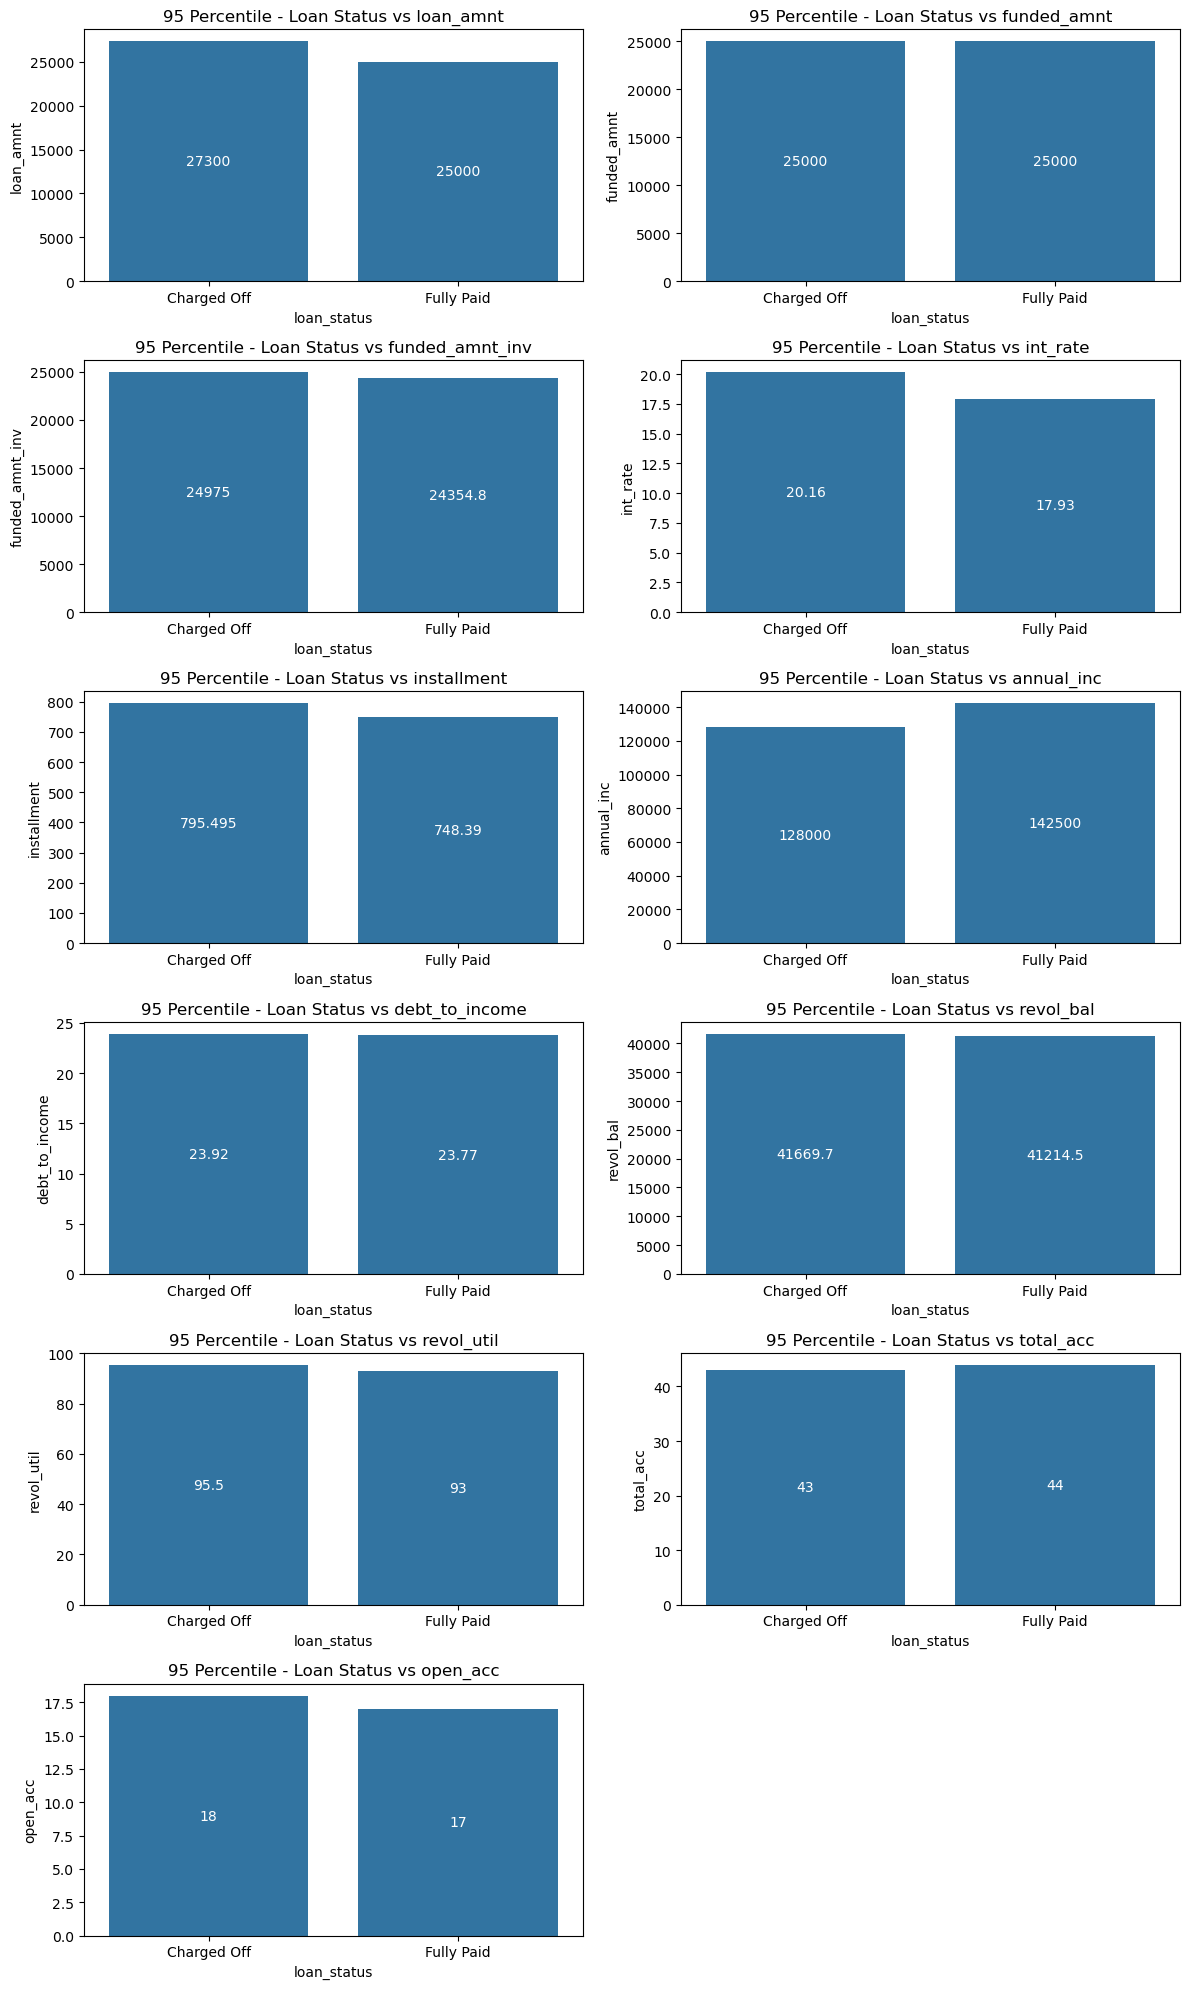

In [52]:
# median values are used to compare
plt.figure(figsize=(12,20))
for i, col in enumerate(num_cols):
    plt.subplot(6,2,i+1)
    ax = sns.barplot(df.groupby('loan_status')[col].quantile(0.95)) #type:ignore
    plt.bar_label(ax.containers[0], label_type='center', color='w') #type:ignore
    plt.title("95 Percentile - Loan Status vs " + col)
    plt.tight_layout()
plt.show()

Observations:

By looking at 95 percentile data, we can take values as a cutoff values.

Indicators for charged off items and limits.
- loan amount: 25000 is 95 percentile value from fully paid items. Above this value, there is a chance of default.
- interest rate: 17.93% is 95 percentile value from fully paid items. Above this value, there is a chance of default. 
- Annual income: 1,30,000 is 95 percentile value from charge off items. below this value, there is a chance of default.

#### bivariate with loan_status and categorical columns

In [53]:
# functions for finding loan charged off proportion
def Chargedoff_Proportion(col):
    Chargedoff_Proportion_df = df.groupby([col, 'loan_status'], observed=False).loan_status.count().unstack().fillna(0).reset_index()
    Chargedoff_Proportion_df['Total'] = Chargedoff_Proportion_df['Charged Off'] + Chargedoff_Proportion_df['Fully Paid'] 
    Chargedoff_Proportion_df['Chargedoff_Proportion'] = round(Chargedoff_Proportion_df['Charged Off'] / Chargedoff_Proportion_df['Total'],2)
    Chargedoff_Proportion_df.sort_values('Chargedoff_Proportion', ascending=False)
    return Chargedoff_Proportion_df

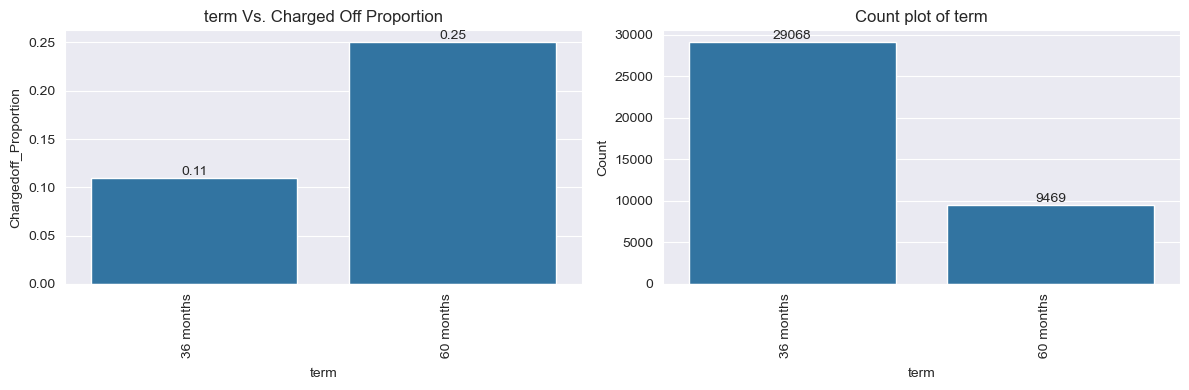

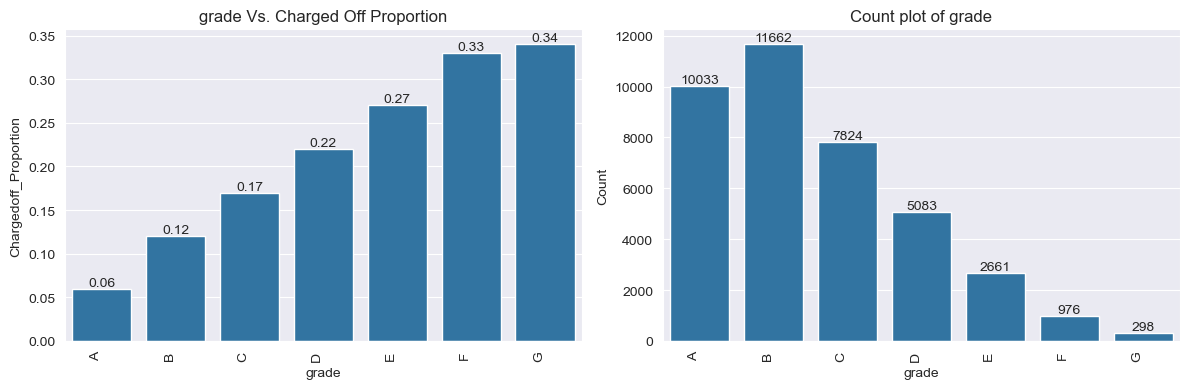

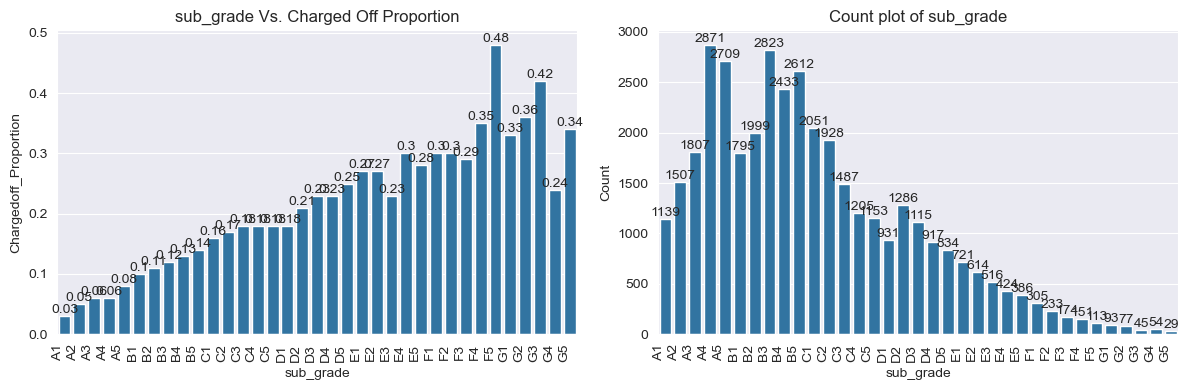

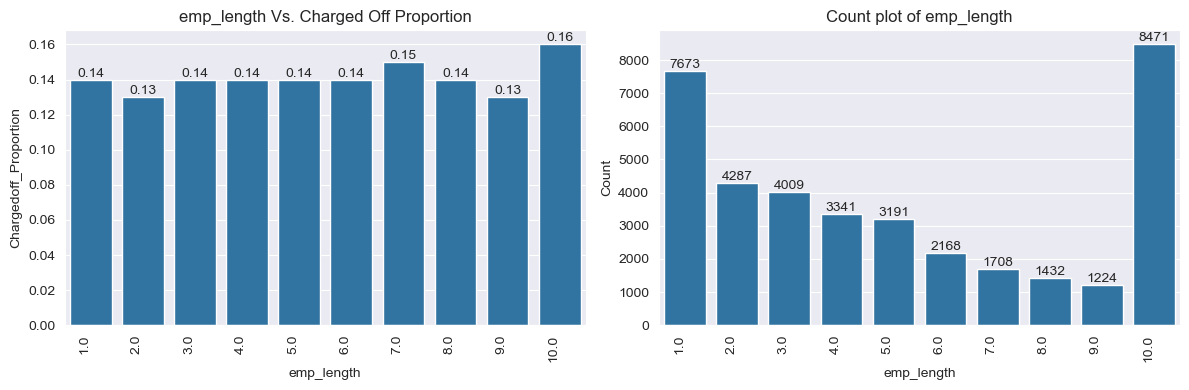

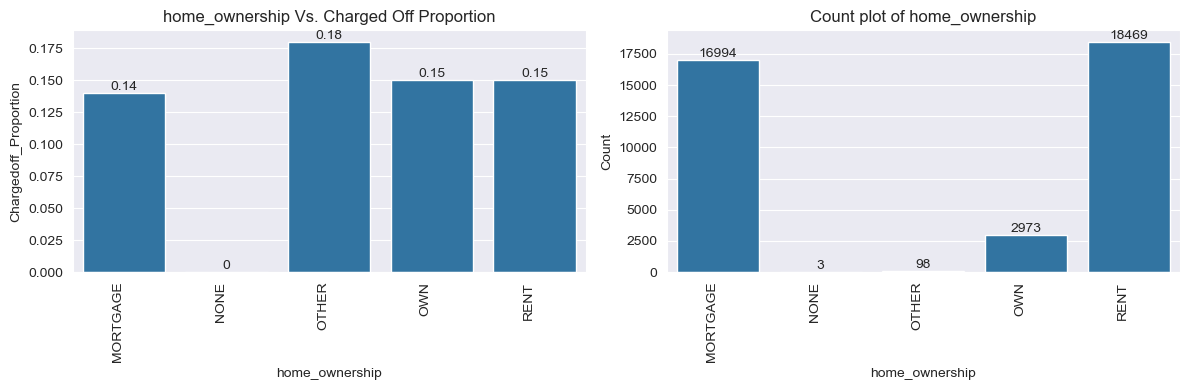

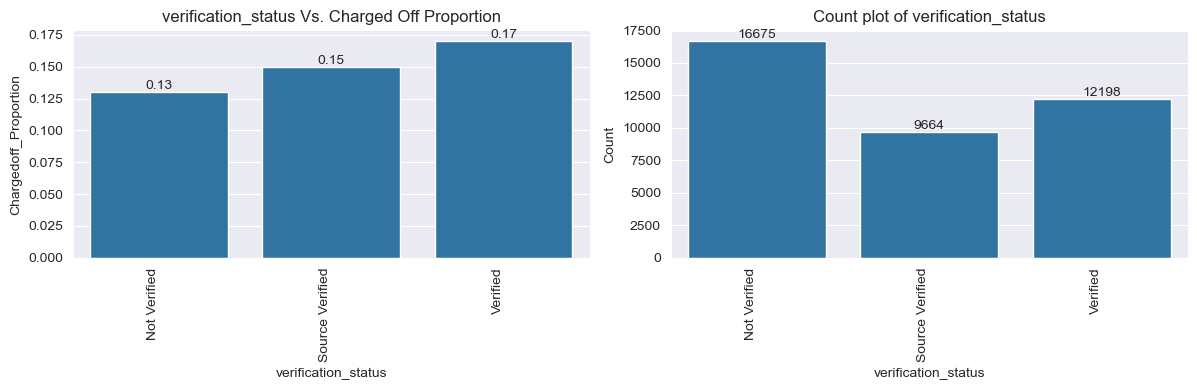

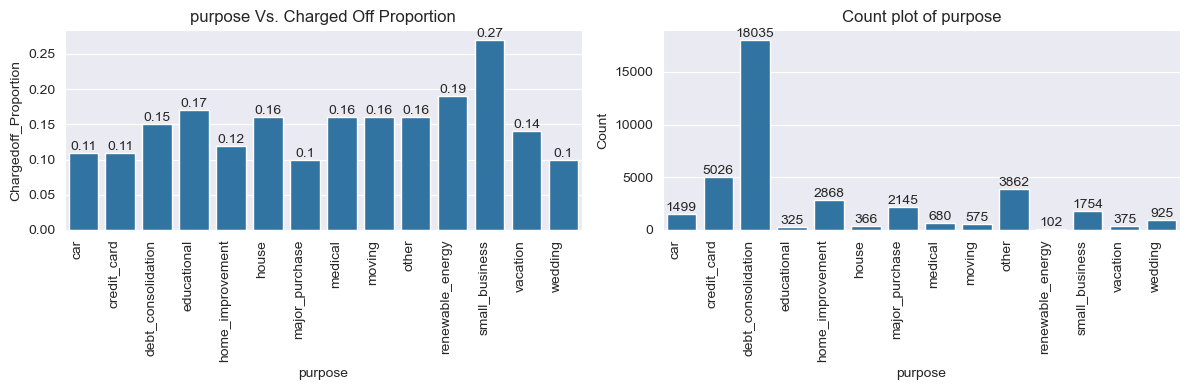

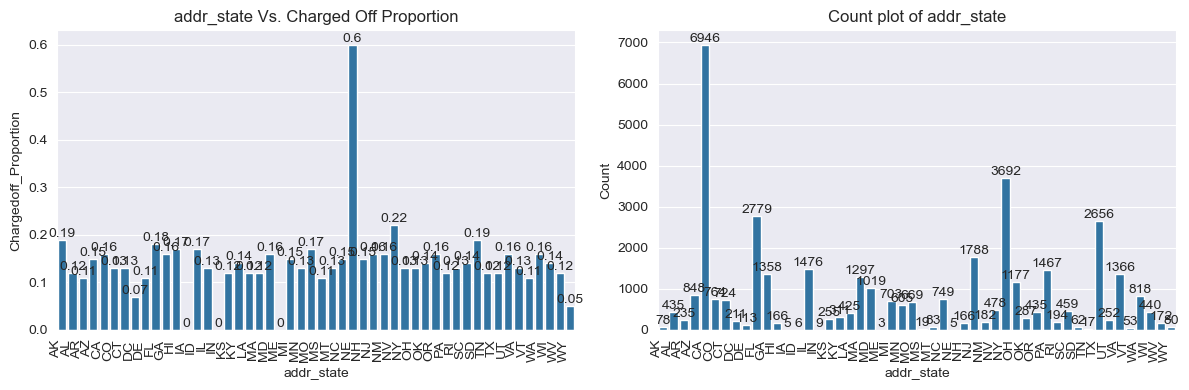

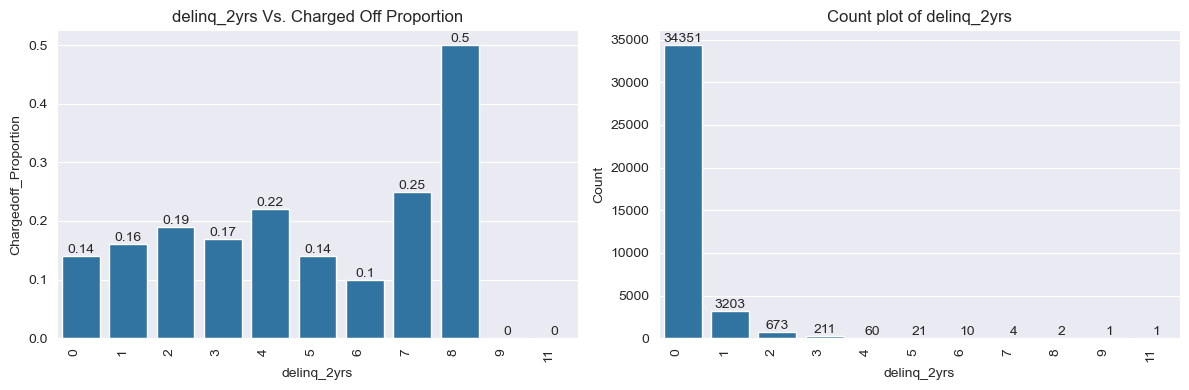

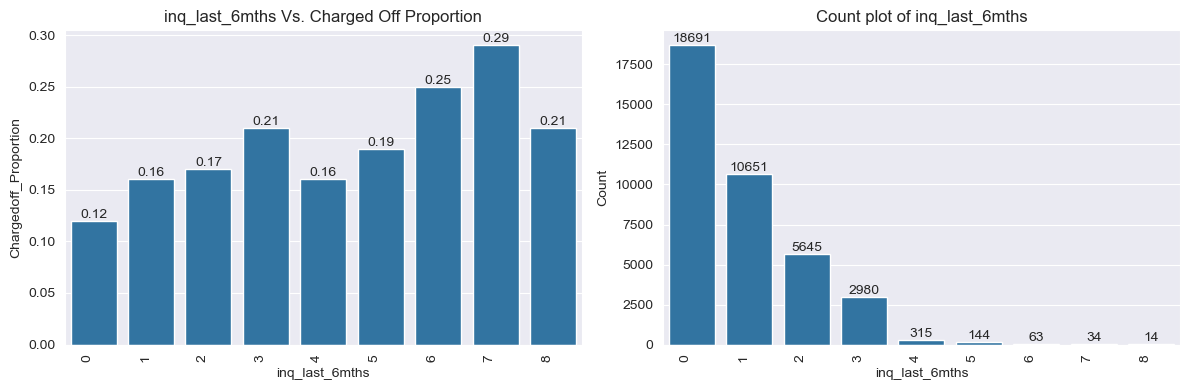

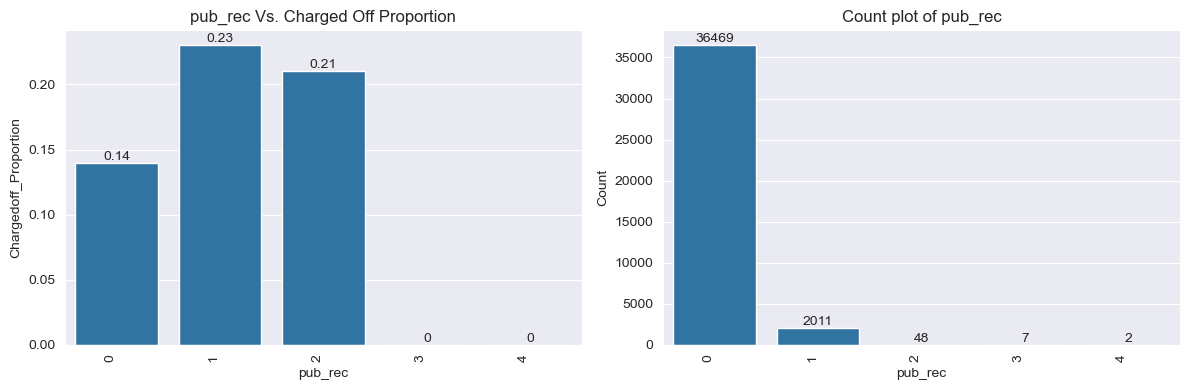

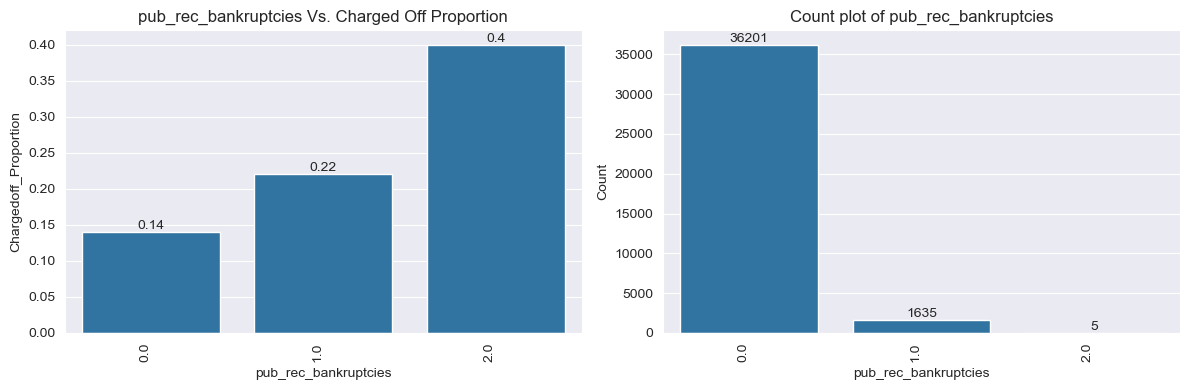

In [54]:
sns.set_style('darkgrid')
for i,col in enumerate(cat_cols):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    ax = sns.barplot(data=Chargedoff_Proportion(col), x=col, y='Chargedoff_Proportion')
    ax.set(title = col + ' Vs. Charged Off Proportion', xlabel=col)
    ax.bar_label(ax.containers[0]) #type: ignore
    fig.autofmt_xdate(rotation=90)

    plt.subplot(1,2,2)
    ax = sns.barplot(data=Chargedoff_Proportion(col), x=col, y='Total')
    ax.set(title = f"Count plot of {col}", xlabel=col)
    ax.set_ylabel("Count")
    ax.bar_label(ax.containers[0]) #type: ignore
    fig.autofmt_xdate(rotation=90)

    plt.tight_layout()
    # plt.xticks(rotation=90)
    plt.show()

Observations:

- Term: 60 months has higher probability of default.
- Grade: Probability of default increases as grade increases from A to G. LC has done good job in deciding grades.
- Sub grade: Same trend is observed in sub grades as grades. Subgrades makes sense, continue them. G grade does not need subgrades.
- emp length: No impact
- home ownership: no impact
- verification status: surprisingly verified items has higher default. Need to recheck on verification process.
- purpose: small business and debt consolidation has higher default. some other types shows higher default, but their count is low to take any decision.
- state: NY has higher default probability with decent count.
- delinq_2yrs: as delinq cases increases, default rate increases. But good cutoff is more than 1.
- inq_last_6mnths: as inquireies increases, default rate increases. But good cutoff is more than 2.
- pub_rec: more than 0 can be good cutoff. As records increases, default prob increases.
- pub_rec_bankrupties: as cases increases, dafault rate increases. good cuutoff is more than 0.

#### loan status vs Date columns

In [55]:
date_cols

['issue_date', 'earliest_cr_line']

In [56]:
# extracting month and year
df['issue_mnth'] = df['issue_date'].dt.month
df['issue_year'] = df['issue_date'].dt.year
df['earliest_cr_line_mnth'] = df['earliest_cr_line'].dt.month
df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year

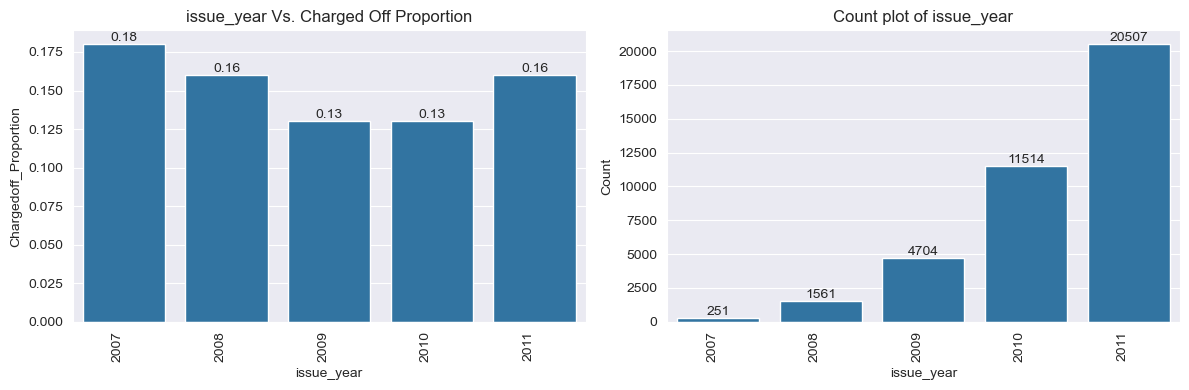

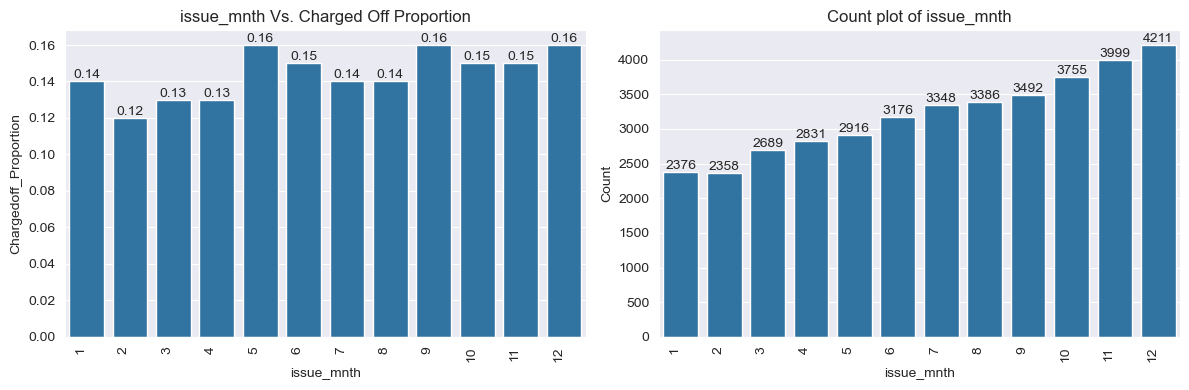

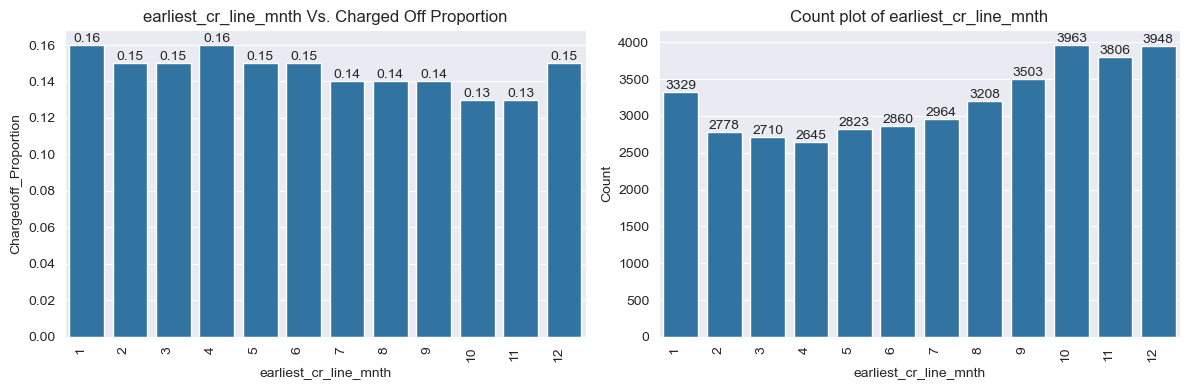

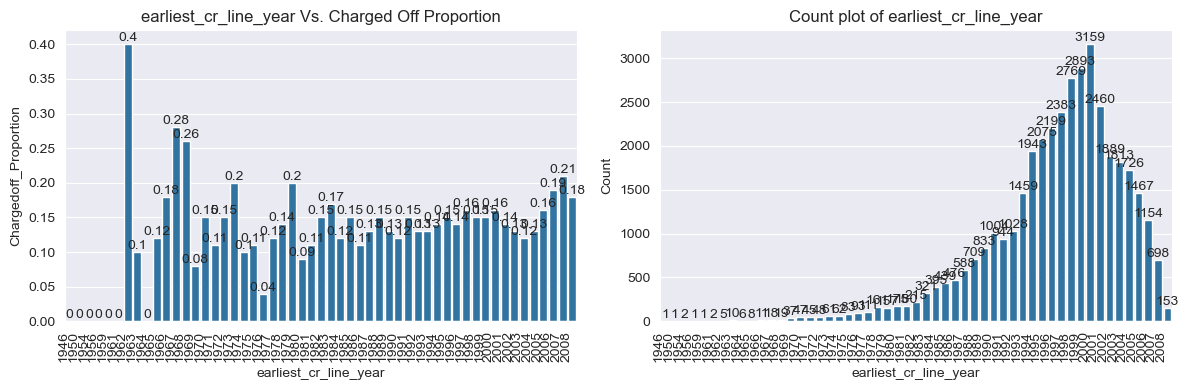

In [57]:
for col in ['issue_year', 'issue_mnth', 'earliest_cr_line_mnth', 'earliest_cr_line_year']:
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    ax = sns.barplot(data=Chargedoff_Proportion(col), x=col, y='Chargedoff_Proportion')
    ax.set(title = col + ' Vs. Charged Off Proportion', xlabel=col)
    ax.bar_label(ax.containers[0]) #type: ignore
    fig.autofmt_xdate(rotation=90)

    plt.subplot(1,2,2)
    ax = sns.barplot(data=Chargedoff_Proportion(col), x=col, y='Total')
    ax.set(title = f"Count plot of {col}", xlabel=col)
    ax.set_ylabel("Count")
    ax.bar_label(ax.containers[0]) #type: ignore
    fig.autofmt_xdate(rotation=90)

    plt.tight_layout()
    # plt.xticks(rotation=90)
    plt.show()

Issue dates:
- Towards the end of the year, loans are increased. But, no trend in default porbaiblity over months
- As year progress from 2007 to 2011 , loans are increased. from 2007 to 2009 charged off proportion decreased, after that, it increased. So, trend may continue. need to be careful.

earliest credit line:
- people oldest opened credit account was in 1946.
- Many people opened their first credit account in 2001. the trend was raiing till 2001, after that it dropped. But no trend is observed in charged off proportion, it was high in 1963, but account were low, no decision can be taken.
- many people opened their first credit account in the months of Oct to Jan. but, no trend observed for charged off proportions.

#### Creating Bins for important numerical columns for group based analysis

In [58]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,38537.0,11043.919480,7345.344493,500.00,5300.00,9600.00,15000.00,35000.00
funded_amnt,38537.0,10780.985806,7087.032648,500.00,5200.00,9525.00,15000.00,35000.00
funded_amnt_inv,38537.0,10219.550468,7019.612638,0.00,5000.00,8725.00,14000.00,35000.00
int_rate,38537.0,11.932719,3.691611,5.42,8.94,11.71,14.42,24.40
installment,38537.0,322.378369,208.534515,15.69,165.74,277.86,425.55,1305.19
annual_inc,38537.0,67622.815809,43532.969574,4000.00,40000.00,58800.00,82000.00,667680.00
debt_to_income,38537.0,13.284026,6.666168,0.00,8.15,13.38,18.56,29.99
revol_bal,38537.0,13282.795703,15861.565836,0.00,3650.00,8761.00,16903.00,149588.00
revol_util,38487.0,48.707753,28.365340,0.00,25.20,49.10,72.30,99.90
total_acc,38537.0,22.049096,11.424068,2.00,13.00,20.00,29.00,90.00


In [59]:
# only bins created for important columns
df['loan_amnt_bins']=pd.cut(df['loan_amnt'],[0,5000,10000,15000,40000],labels=['0-5000','5000-10000','10000-15000','15000+'])
df['int_rate_bins']=pd.cut(df['int_rate'],[0,9,12,15,25],labels=['0-9','9-12','12-15','15+'])
df['annual_inc_bins']=pd.cut(df['annual_inc'],[0,40000,60000,80000,1500000],labels=['0-40000','40000-60000','60000-80000','80000+'])
df['debt_to_income_bins']=pd.cut(df['debt_to_income'],[0,8,14,20,30],labels=['0-8','8-14','14-20','20+'])
df['revol_util_bins']=pd.cut(df['revol_util'],[0,25,50,75,100],labels=['0-25','25-50','50-75','75-100'])

In [60]:
bin_columns = ['loan_amnt_bins', 'int_rate_bins', 'annual_inc_bins', 'debt_to_income_bins', 'revol_util_bins']

In [61]:
df.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec_bankruptcies,issue_mnth,issue_year,earliest_cr_line_mnth,earliest_cr_line_year,loan_amnt_bins,int_rate_bins,annual_inc_bins,debt_to_income_bins,revol_util_bins
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10.0,RENT,...,0.0,12,2011,1,1985,0-5000,9-12,0-40000,20+,75-100
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,1.0,RENT,...,0.0,12,2011,4,1999,0-5000,15+,0-40000,0-8,0-25
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10.0,RENT,...,0.0,12,2011,11,2001,0-5000,15+,0-40000,8-14,75-100
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10.0,RENT,...,0.0,12,2011,2,1996,5000-10000,12-15,40000-60000,14-20,0-25
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3.0,RENT,...,0.0,12,2011,11,2004,0-5000,0-9,0-40000,8-14,25-50


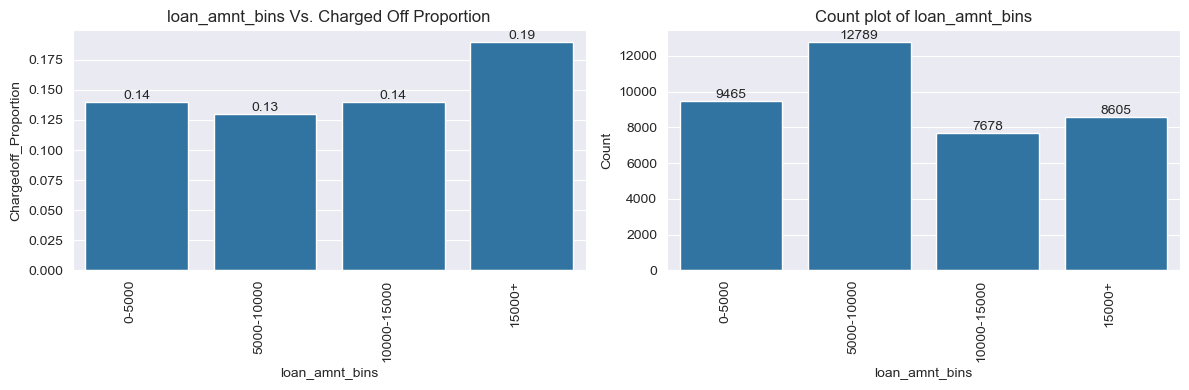

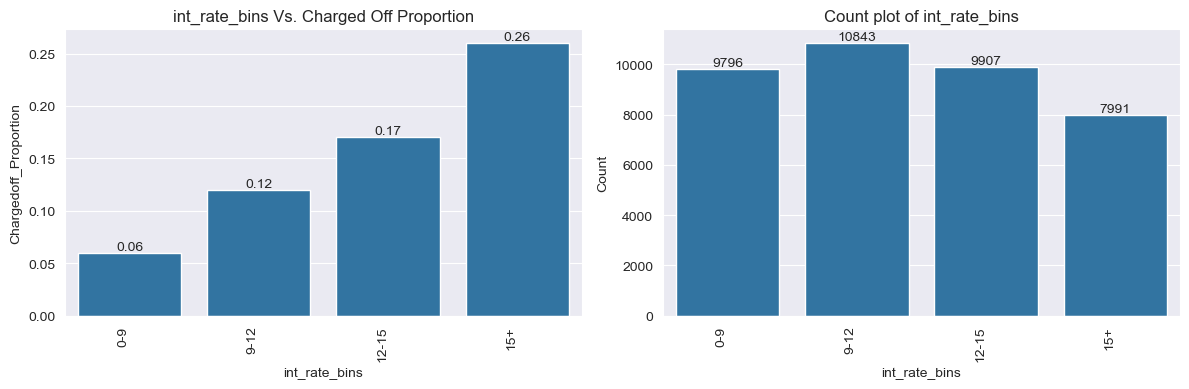

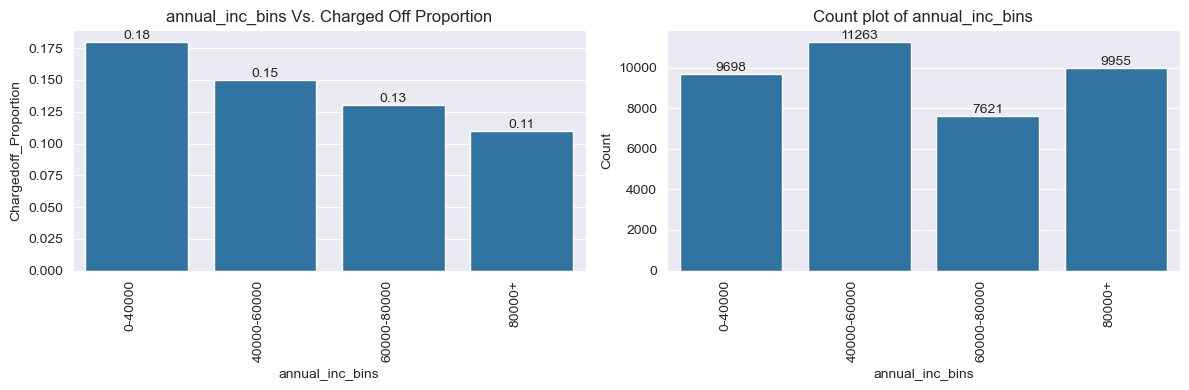

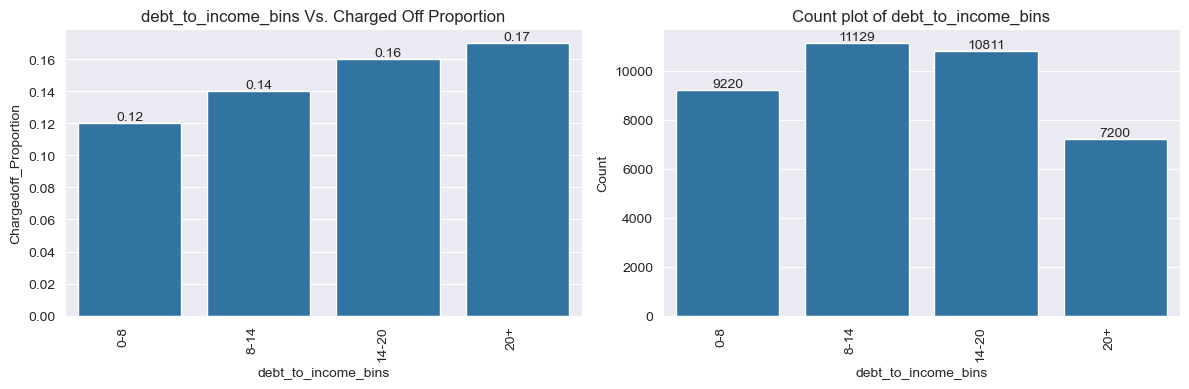

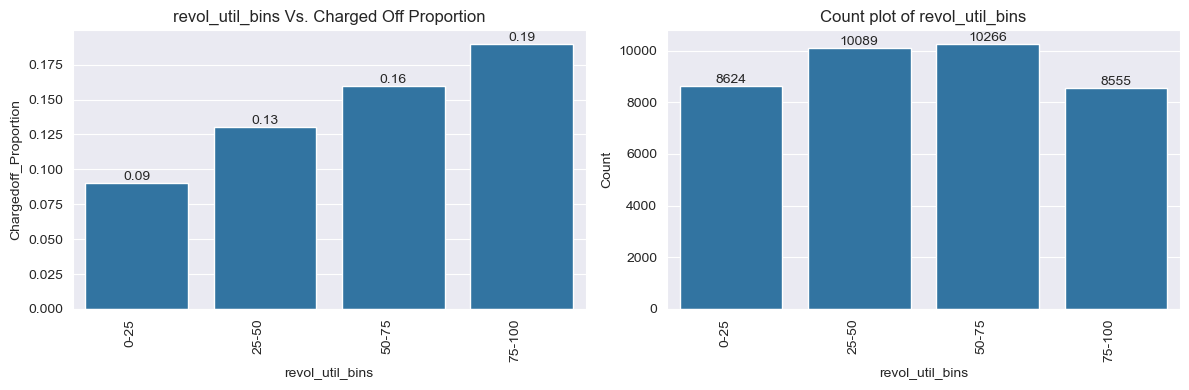

In [62]:
sns.set_style('darkgrid')
for i,col in enumerate(bin_columns):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    ax = sns.barplot(data=Chargedoff_Proportion(col), x=col, y='Chargedoff_Proportion')
    ax.set(title = col + ' Vs. Charged Off Proportion', xlabel=col)
    ax.bar_label(ax.containers[0]) #type: ignore
    fig.autofmt_xdate(rotation=90)

    plt.subplot(1,2,2)
    ax = sns.barplot(data=Chargedoff_Proportion(col), x=col, y='Total')
    ax.set(title = f"Count plot of {col}", xlabel=col)
    ax.set_ylabel("Count")
    ax.bar_label(ax.containers[0]) #type: ignore
    fig.autofmt_xdate(rotation=90)

    plt.tight_layout()
    # plt.xticks(rotation=90)
    plt.show()

Observations:
- Rs. 5000 -10000 is the common loan amount. But 15000+ loans has higher probability of default.
- 9-12% is the common interest rate. Default probability increases as interest rate increases.
- Rs. 40,000 - 60,000 is the common annual income. Default probability increase as annual income reduces.
- 8-14 is the most common debt to income ratio. As debt to income ratio increases, default probability increases.
- 25-75 is the common revolving credit utilization. As credit utilization increases, default probability increases.

### Segmented Analysis

Some of the important variables after above analysis are: 
- Loan amount, interest rate, annual income, debt to income ratio, revolving credit utilization.
- Term, grade, Loan purpose
- bin_columns = ['loan_amnt_bins', 'int_rate_bins', 'annual_inc_bins', 'debt_to_income_bins', 'revol_util_bins']

The purpose of loan is one of the major driving factor, that will be analyzed below

In [63]:
df['purpose'].value_counts().sort_values(ascending=False)

purpose
debt_consolidation    18035
credit_card            5026
other                  3862
home_improvement       2868
major_purchase         2145
small_business         1754
car                    1499
wedding                 925
medical                 680
moving                  575
vacation                375
house                   366
educational             325
renewable_energy        102
Name: count, dtype: int64

In [64]:
# creating seperate df for major loan columns
major_purpose = ['debt_consolidation', 'credit_card', 'home_improvement', 'major_purchase', 'small_business']
df_purpose = df[df['purpose'].isin(major_purpose)]

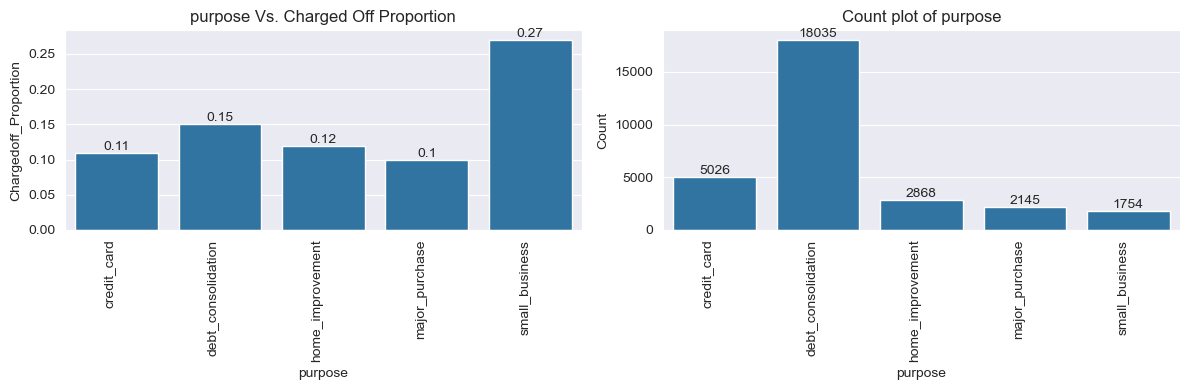

In [65]:
# function for finding loan charged off proportion for the new df with major loan pruposes.
def Chargedoff_Proportion_segmented(col):
    Chargedoff_Proportion_df = df_purpose.groupby([col, 'loan_status'], observed=False).loan_status.count().unstack().fillna(0).reset_index()
    Chargedoff_Proportion_df['Total'] = Chargedoff_Proportion_df['Charged Off'] + Chargedoff_Proportion_df['Fully Paid'] 
    Chargedoff_Proportion_df['Chargedoff_Proportion'] = round(Chargedoff_Proportion_df['Charged Off'] / Chargedoff_Proportion_df['Total'],2)
    Chargedoff_Proportion_df.sort_values('Chargedoff_Proportion', ascending=False)
    return Chargedoff_Proportion_df

sns.set_style('darkgrid')
col = 'purpose'

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = sns.barplot(data=Chargedoff_Proportion_segmented(col), x=col, y='Chargedoff_Proportion')
ax.set(title = col + ' Vs. Charged Off Proportion', xlabel=col)
ax.bar_label(ax.containers[0]) #type: ignore
fig.autofmt_xdate(rotation=90)

plt.subplot(1,2,2)
ax = sns.barplot(data=Chargedoff_Proportion_segmented(col), x=col, y='Total')
ax.set(title = f"Count plot of {col}", xlabel=col)
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0]) #type: ignore
fig.autofmt_xdate(rotation=90)

plt.tight_layout()
plt.show()

Majotiy loans are for debt consolidation. But, small business loans have higher default probability. 

In [66]:
# function for finding loan charged off proportion for two columns
def Chargedoff_Proportion_for_two_columns(col1, col2):
    Chargedoff_Proportion_df = df_purpose.groupby([col1, col2, 'loan_status'], observed=False).loan_status.count().unstack().fillna(0).reset_index()
    Chargedoff_Proportion_df['Total'] = Chargedoff_Proportion_df['Charged Off'] + Chargedoff_Proportion_df['Fully Paid'] 
    Chargedoff_Proportion_df['Chargedoff_Proportion'] = round(Chargedoff_Proportion_df['Charged Off'] / Chargedoff_Proportion_df['Total'],2)
    Chargedoff_Proportion_df.sort_values('Chargedoff_Proportion', ascending=False)
    return Chargedoff_Proportion_df

In [67]:
columns_for_segmented = ['term', 'grade', 'issue_year'] + bin_columns

columns_for_segmented

['term',
 'grade',
 'issue_year',
 'loan_amnt_bins',
 'int_rate_bins',
 'annual_inc_bins',
 'debt_to_income_bins',
 'revol_util_bins']

#### segmented loan purpose

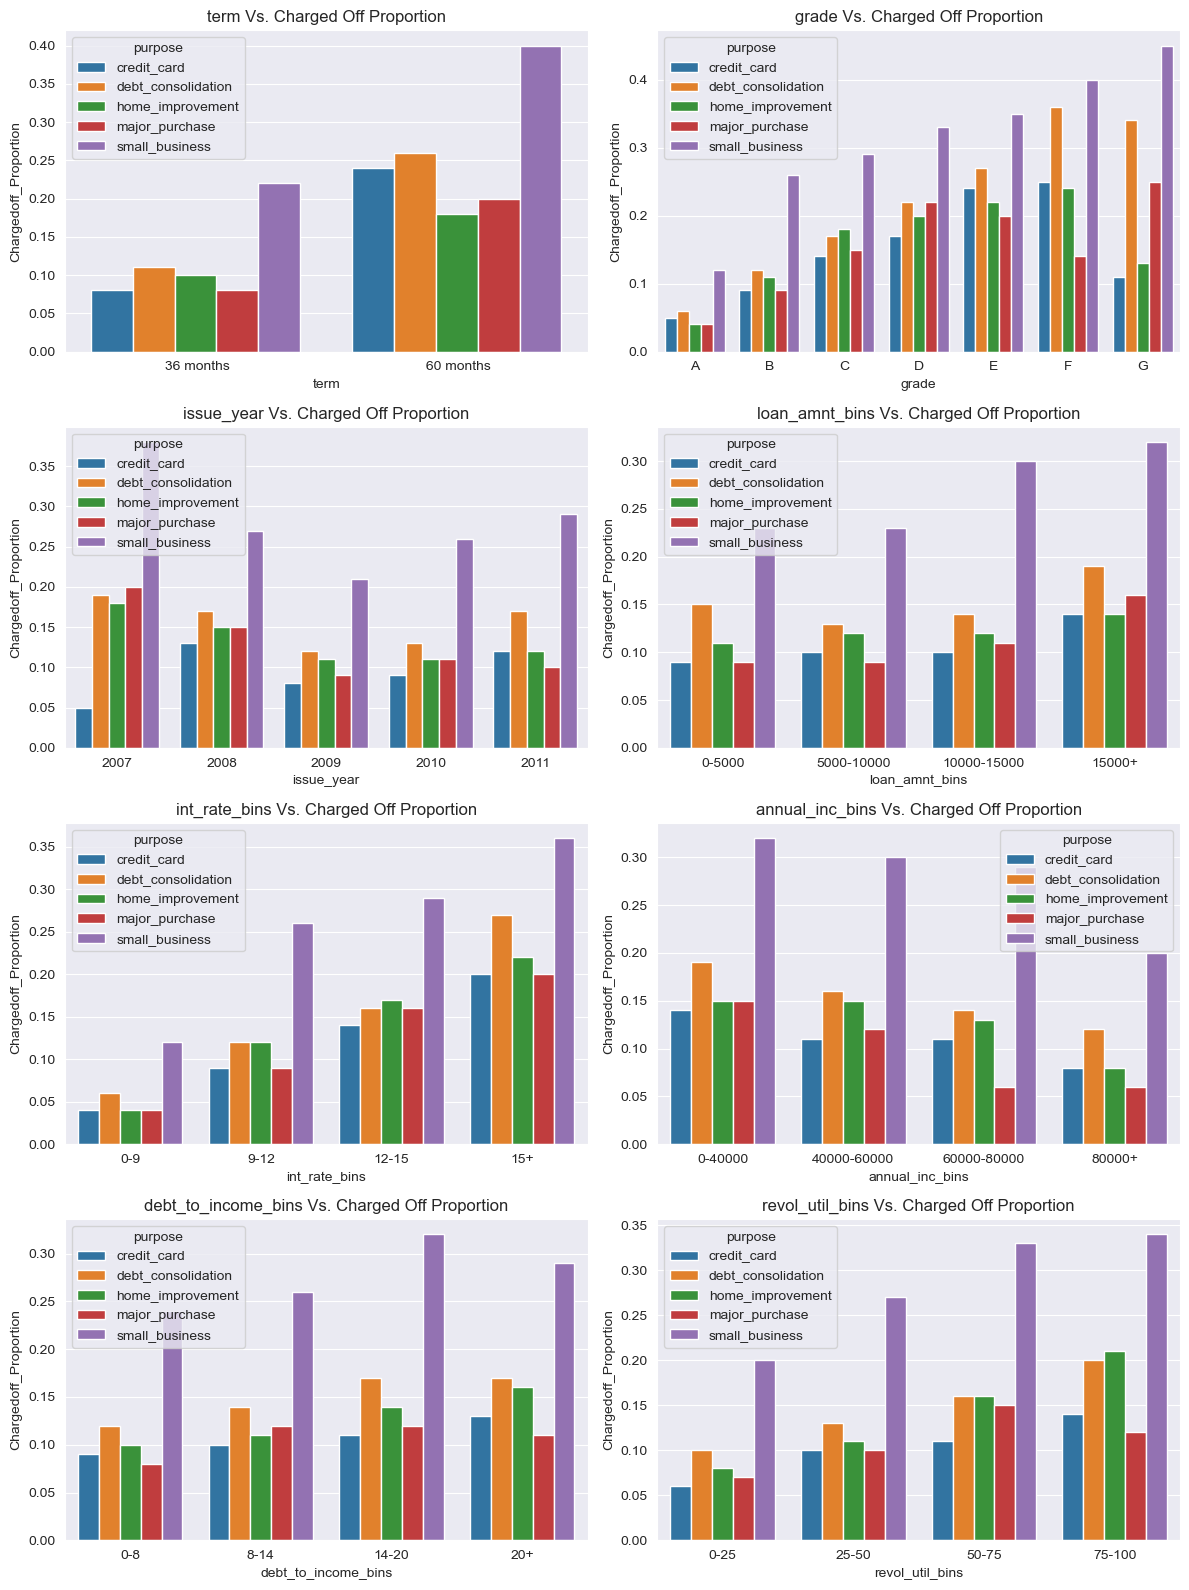

In [68]:
columns_for_segmented = ['term', 'grade', 'issue_year'] + bin_columns

sns.set_style('darkgrid')
col1 = 'purpose'

fig = plt.figure(figsize=(12,16))

for i, col2 in enumerate(columns_for_segmented):
    plt.subplot(4,2,i+1)
    ax = sns.barplot(data=Chargedoff_Proportion_for_two_columns(col1, col2), x=col2, hue=col1, y='Chargedoff_Proportion')
    ax.set(title = f"{col2} Vs. Charged Off Proportion", xlabel=col2)
    # ax.bar_label(ax.containers[0]) #type: ignore
    # fig.autofmt_xdate(rotation=90)

    plt.tight_layout()
    # plt.xticks(rotation=90)
plt.show()

observations:
- among all the plots, obersvations are consistent across different segments.
- small business loans are having higher default ratios. Debt consolidation is next to it.

#### segmented for loan amount bins

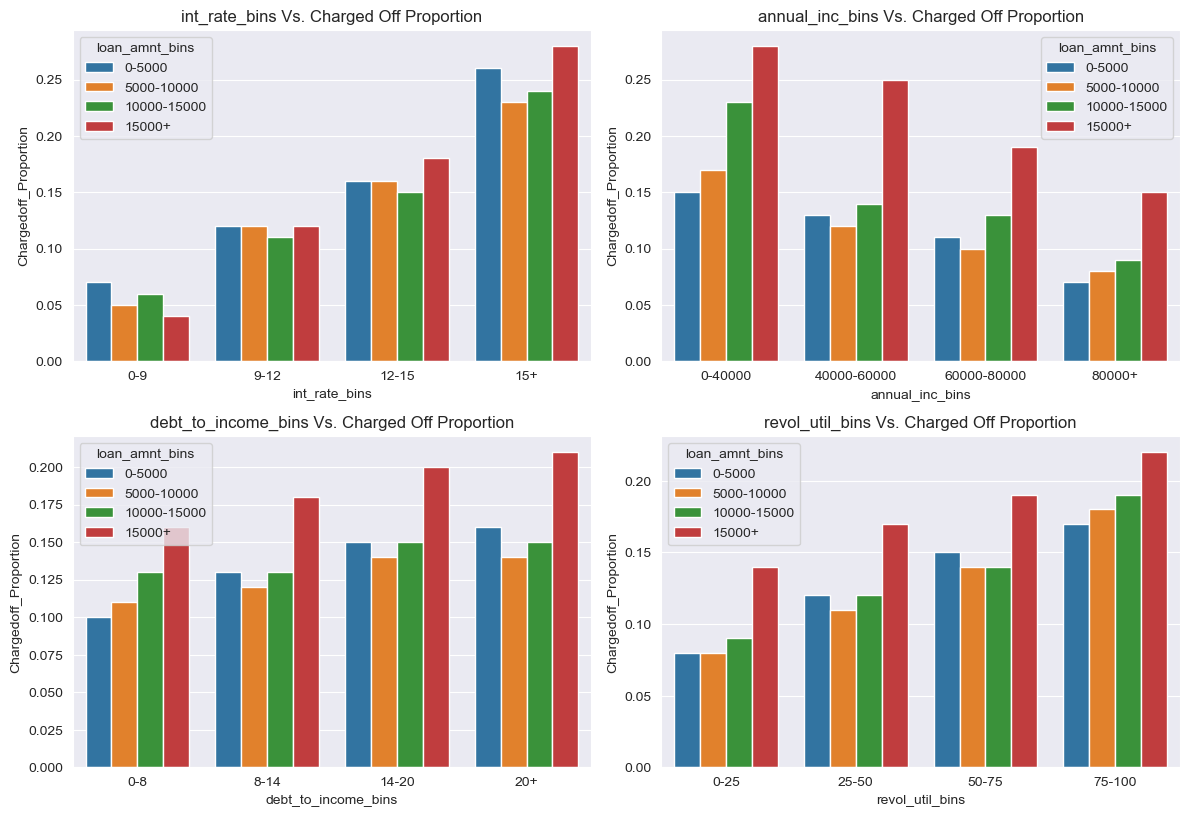

In [69]:
columns_for_segmented = bin_columns.copy()

sns.set_style('darkgrid')
col1 = 'loan_amnt_bins'
columns_for_segmented.remove(col1)

fig = plt.figure(figsize=(12,16))
for i, col2 in enumerate(columns_for_segmented):
    plt.subplot(4,2,i+1)
    ax = sns.barplot(data=Chargedoff_Proportion_for_two_columns(col1, col2), x=col2, hue=col1, y='Chargedoff_Proportion')
    ax.set(title = f"{col2} Vs. Charged Off Proportion", xlabel=col2)
    plt.tight_layout()

plt.show()

Higher Default Probability Ranges:

Rs. 15000+ loan amount and
- 15%+ interest rate
- 0-40000 Annual income
- 20+ debt to income ratio
- 75-100% revolving credit utilization 

#### segmented for Interest Rate bins

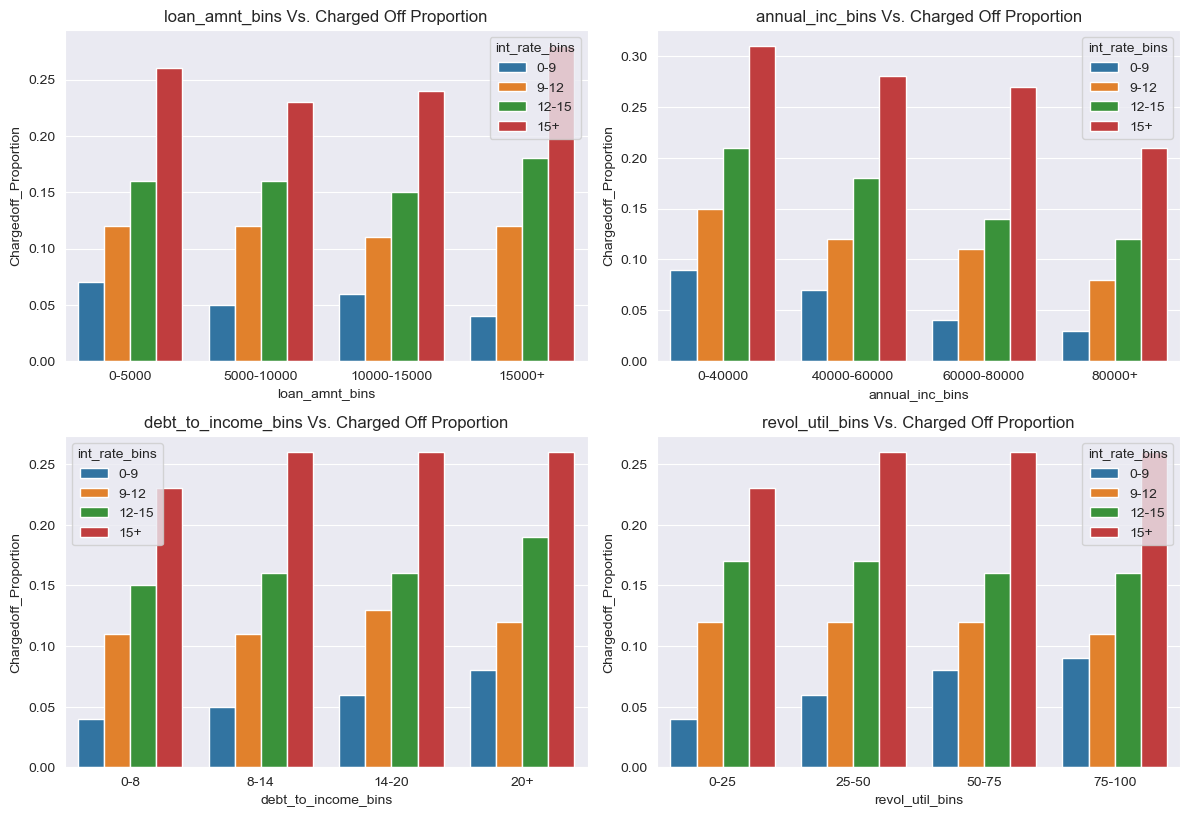

In [70]:
columns_for_segmented = bin_columns.copy()

sns.set_style('darkgrid')
col1 = 'int_rate_bins'
columns_for_segmented.remove(col1)

fig = plt.figure(figsize=(12,16))
for i, col2 in enumerate(columns_for_segmented):
    plt.subplot(4,2,i+1)
    ax = sns.barplot(data=Chargedoff_Proportion_for_two_columns(col1, col2), x=col2, hue=col1, y='Chargedoff_Proportion')
    ax.set(title = f"{col2} Vs. Charged Off Proportion", xlabel=col2)
    plt.tight_layout()

plt.show()

Higher Default Probability Ranges:

Rs. 15%+ interest rate and
- 0-40000 Annual income
- 20+ debt to income ratio
- 75-100% revolving credit utilization 

#### segmented for Annual income bins

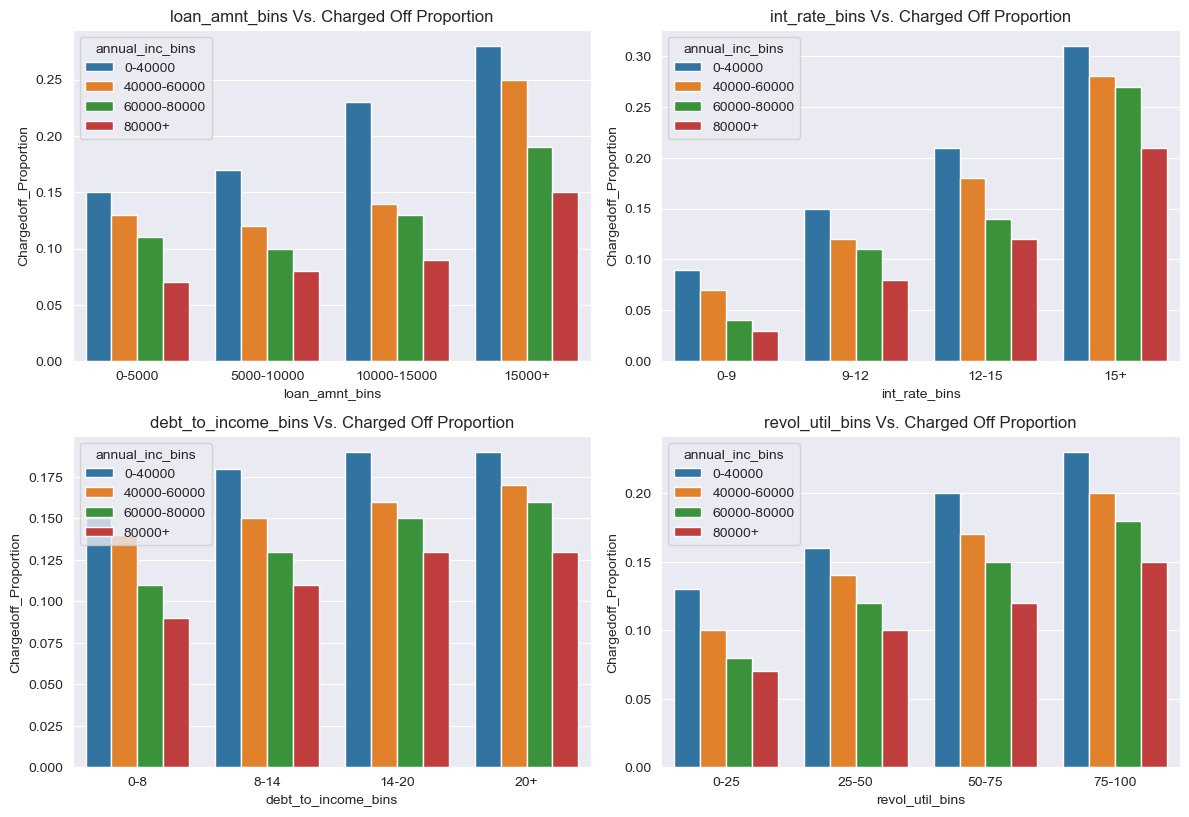

In [71]:
columns_for_segmented = bin_columns.copy()

sns.set_style('darkgrid')
col1 = 'annual_inc_bins'
columns_for_segmented.remove(col1)

fig = plt.figure(figsize=(12,16))
for i, col2 in enumerate(columns_for_segmented):
    plt.subplot(4,2,i+1)
    ax = sns.barplot(data=Chargedoff_Proportion_for_two_columns(col1, col2), x=col2, hue=col1, y='Chargedoff_Proportion')
    ax.set(title = f"{col2} Vs. Charged Off Proportion", xlabel=col2)
    plt.tight_layout()

plt.show()

Higher Default Probability Ranges:

Rs. 0-40000 Annual income and 
- 20+ debt to income ratio
- 75-100% revolving credit utilization 

### Multi variate Analysis

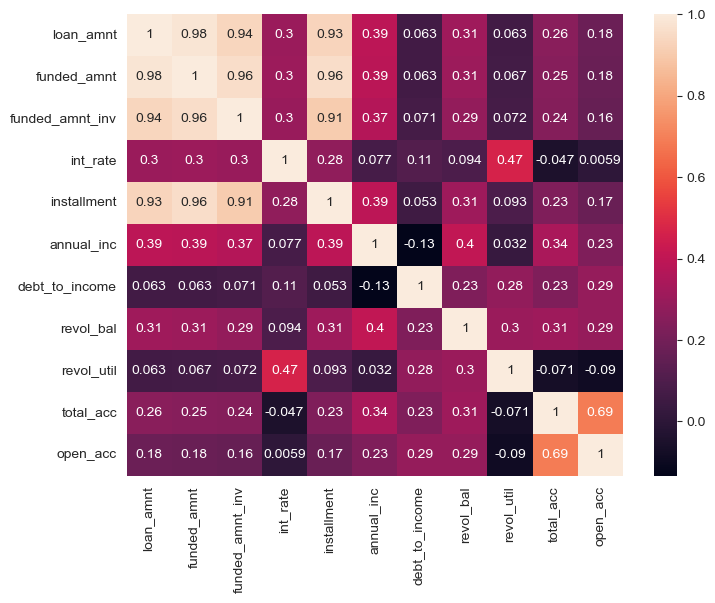

In [72]:
# heatmap between numerical columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(),annot=True) #type: ignore
plt.show()

Observations:
- > \>0.4 and <-0.4 is used as reasonable positive or negetive correlation, -0.1 to 0.1 is used for no correlation.
- Loan amount, funded amount, funded amount inversted are strongly correlated.
- Loan amount is postively correlated to Annual income.
- loan amount is not correlated to debt to income ratio and revolving utilizaion.
- Interest rate is higher for people with high revolving credit utlization.
- Interest rate is not correlated to annaul income, revolving credit balance, total and open accounts.
- Annual income is correlated postively to revolving balance. And it is not correlated to revolving utilization.
- revolving utilziaiton is not correlated to total and open accounts. 

### The END - Thank You